# **Róbert Šafár** & **Matúš Totcimak**
## 2. fáza: *Predspracovanie údajov*
#### Dataset 82
#### Podiel práce 0:0
#
#

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from scipy.stats import shapiro
from sklearn.preprocessing import PowerTransformer
import math
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

pd.set_option('display.max_columns', None)

## Načítanie CSV súborov

In [2]:
con = pd.read_csv("dataset82/connections.csv", sep='\t')
proc = pd.read_csv("dataset82/processes.csv", sep='\t')
dev = pd.read_csv("dataset82/devices.csv", sep='\t')
prof = pd.read_csv("dataset82/profiles.csv", sep='\t')

#
# **2.1 Realizácia predspracovania dát**

### Ná základe prvej fázy nebudeme pracovať s `Devices` a `Profiles`.
### `Connections` a `Processes` majú viacero záznamov pre jedno `imei`. To isté platí pre `Devices` a `Profiles`. Keďže tieto DFs dokážeme spojiť len cez `imei`, priraďovali by sme k sebe záznamy, ktoré k sebe nepatria.

#
## *A) Rozdelenie dát na trénovaciu a testovaciu množinu.*

### Pred spojením `Connections` a `Processes` odstránime duplikátne záznamy.

In [3]:
con = con.loc[~con.duplicated()].reset_index(drop=True).copy()
proc = proc.loc[~proc.duplicated()].reset_index(drop=True).copy()

### Spojenie `Connections` a `Processes`.

In [4]:
df = pd.merge(con, proc, on=['ts', 'imei', 'mwra'])

### Nový DF rozdelíme na `data` a `target`.

In [5]:
# Data
X = df.drop(columns=['mwra'])

# Target
y = df[['mwra']]

### Pomer rozdelenia zvolíme `80:20`.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=11, test_size=0.2)

In [7]:
kopia_X = X_train.copy()
kopia_y = y_train.copy()

#
## *B) Transformujte dáta na vhodný formát pre ML.*

### Overenie chýbajúcich hodnôt. Z `EDA` už vieme, že žiadne nie sú.

In [8]:
X_train.isna().sum()[X_train.isna().sum() > 0]

Series([], dtype: int64)

### Vymažeme atribút `imei`, pretože ho nepovažujeme za atribút, ktorý by určoval hodnotu `mwra`. Je to len identifikátor zariadení. Takisto aj `ts`.

In [9]:
X_train = X_train.drop(columns=['ts', 'imei'])

#
### *`Funkcia:`* Vykreslenie Box-plotov pre každý atribút z `df`.

In [10]:
def show_boxplots(df):
    _, ax = plt.subplots(figsize=(17, 7))
    df.boxplot(ax=ax,
                    boxprops=dict(color='#34495E'),
                    flierprops=dict(markeredgecolor='#9B59B6', markersize=5),
                    medianprops=dict(color='#3498DB', linewidth=1.5),
                    capprops=dict(color='black'),
                    whiskerprops=dict(color='black')
                    )
    ax.grid(True, linewidth=0.3)
    plt.xticks(rotation=270)
    plt.title("Boxploty atribútov X_train")
    plt.ylabel("Hodnoty")
    plt.show()

### Zobrazenie atribútov a ich outlierov pomocou `Box-plotov`.

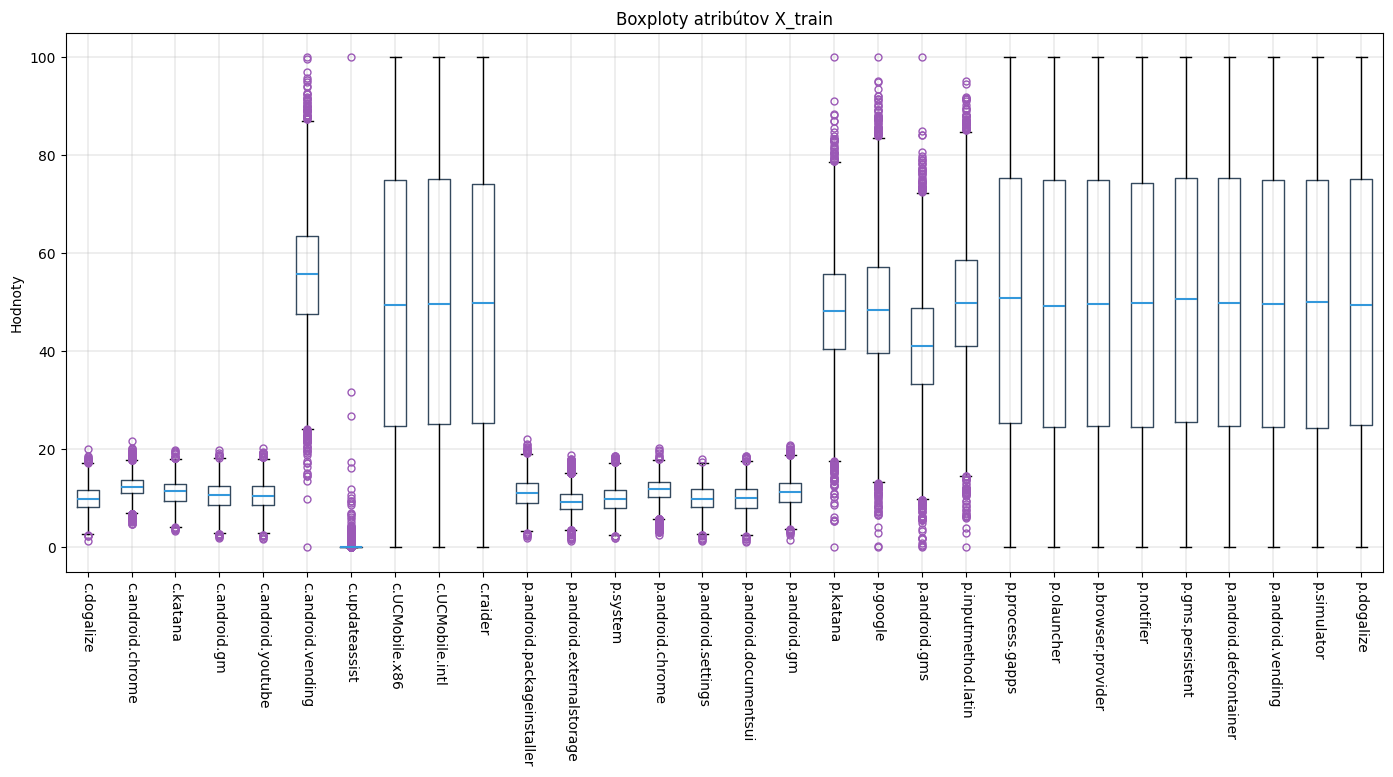

In [11]:
show_boxplots(X_train)

### *`Funckia:`* Zmena outlierov na hraničné hodnoty.

In [12]:
def change_outliers_iqr(df, exceptions):
    for column in df:
        if column in exceptions:
            continue
        
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

### Zmena outlierov pre všetky atribúty `df` okrem `df['c.updateassist']`.

In [13]:
X_train = change_outliers_iqr(X_train, ['c.updateassist'])

### Odstránenie záznamov, kde `df['c.updateassist'] >= 5`. Rovnako ako v `EDA`.

In [14]:
lines_to_remove = X_train[X_train['c.updateassist'] > 5].index
X_train = X_train.drop(lines_to_remove)
y_train = y_train.drop(lines_to_remove)

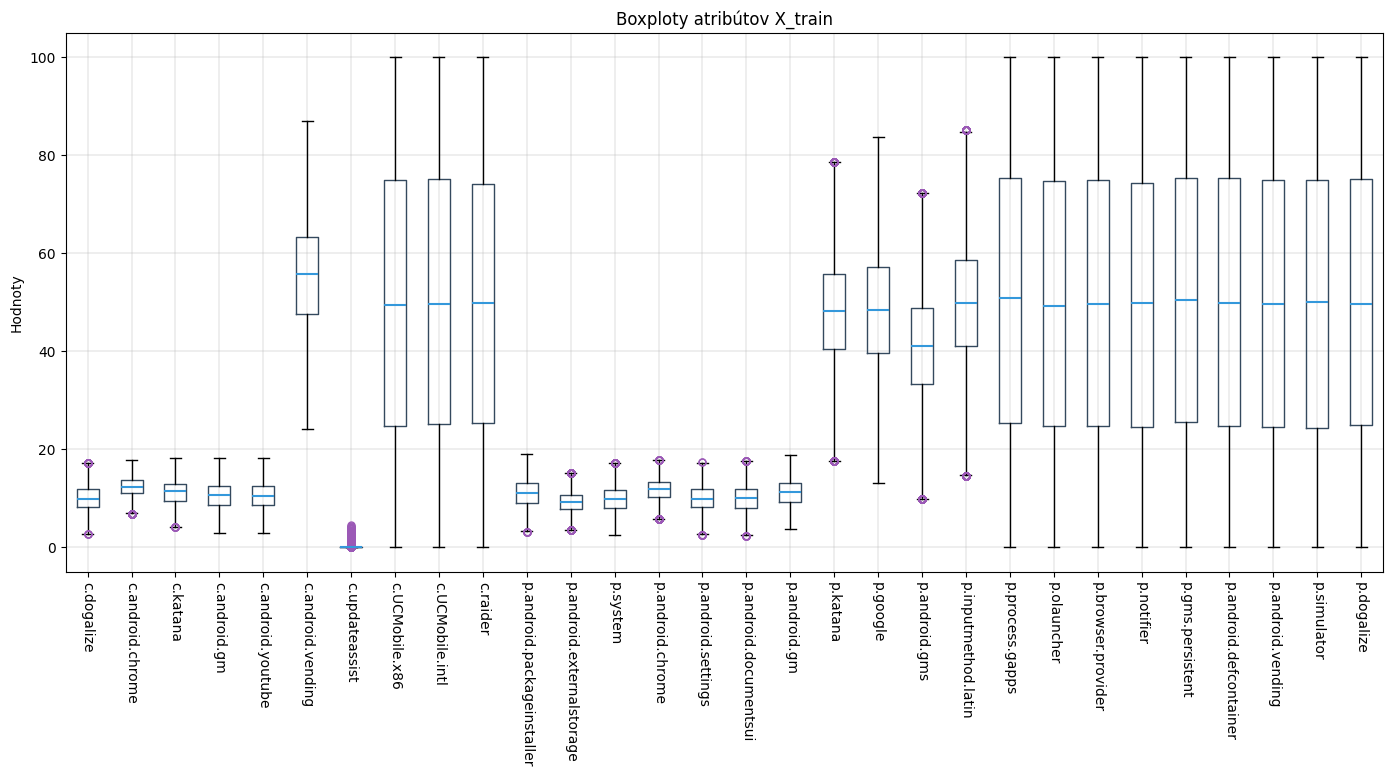

In [15]:
show_boxplots(X_train)

### Niektoré outliery zostali, pretože sa nachádzajú blízko dolnej/hornej hranice. Môžeme ich však považovať za zanedbateľné. Rovnako sme postupovali s outliermi v `EDA`.

#
## *C) Transformujte atribúty dát pre strojové učenie.*

### `Funkcia:` Vykreslenie `KDE` grafov pre `DF`.

In [16]:
def show_kde_graphs(df, attributes):
    num_attributes = len(attributes)

    if num_attributes == 0:
        print("No attributes to show")
        return
    
    cols = min(5, num_attributes)
    rows = math.ceil(num_attributes / cols)
    
    plt.figure(figsize=(cols * 4, rows * 4))

    for i, column in enumerate(attributes):
        plt.subplot(rows, cols, i + 1)
        sns.kdeplot(df[column], fill=True, color='blue', alpha=0.5)
        plt.title(column)
        plt.xlabel('Hodnoty')
        plt.ylabel('Hustota')

    plt.tight_layout()
    plt.show()

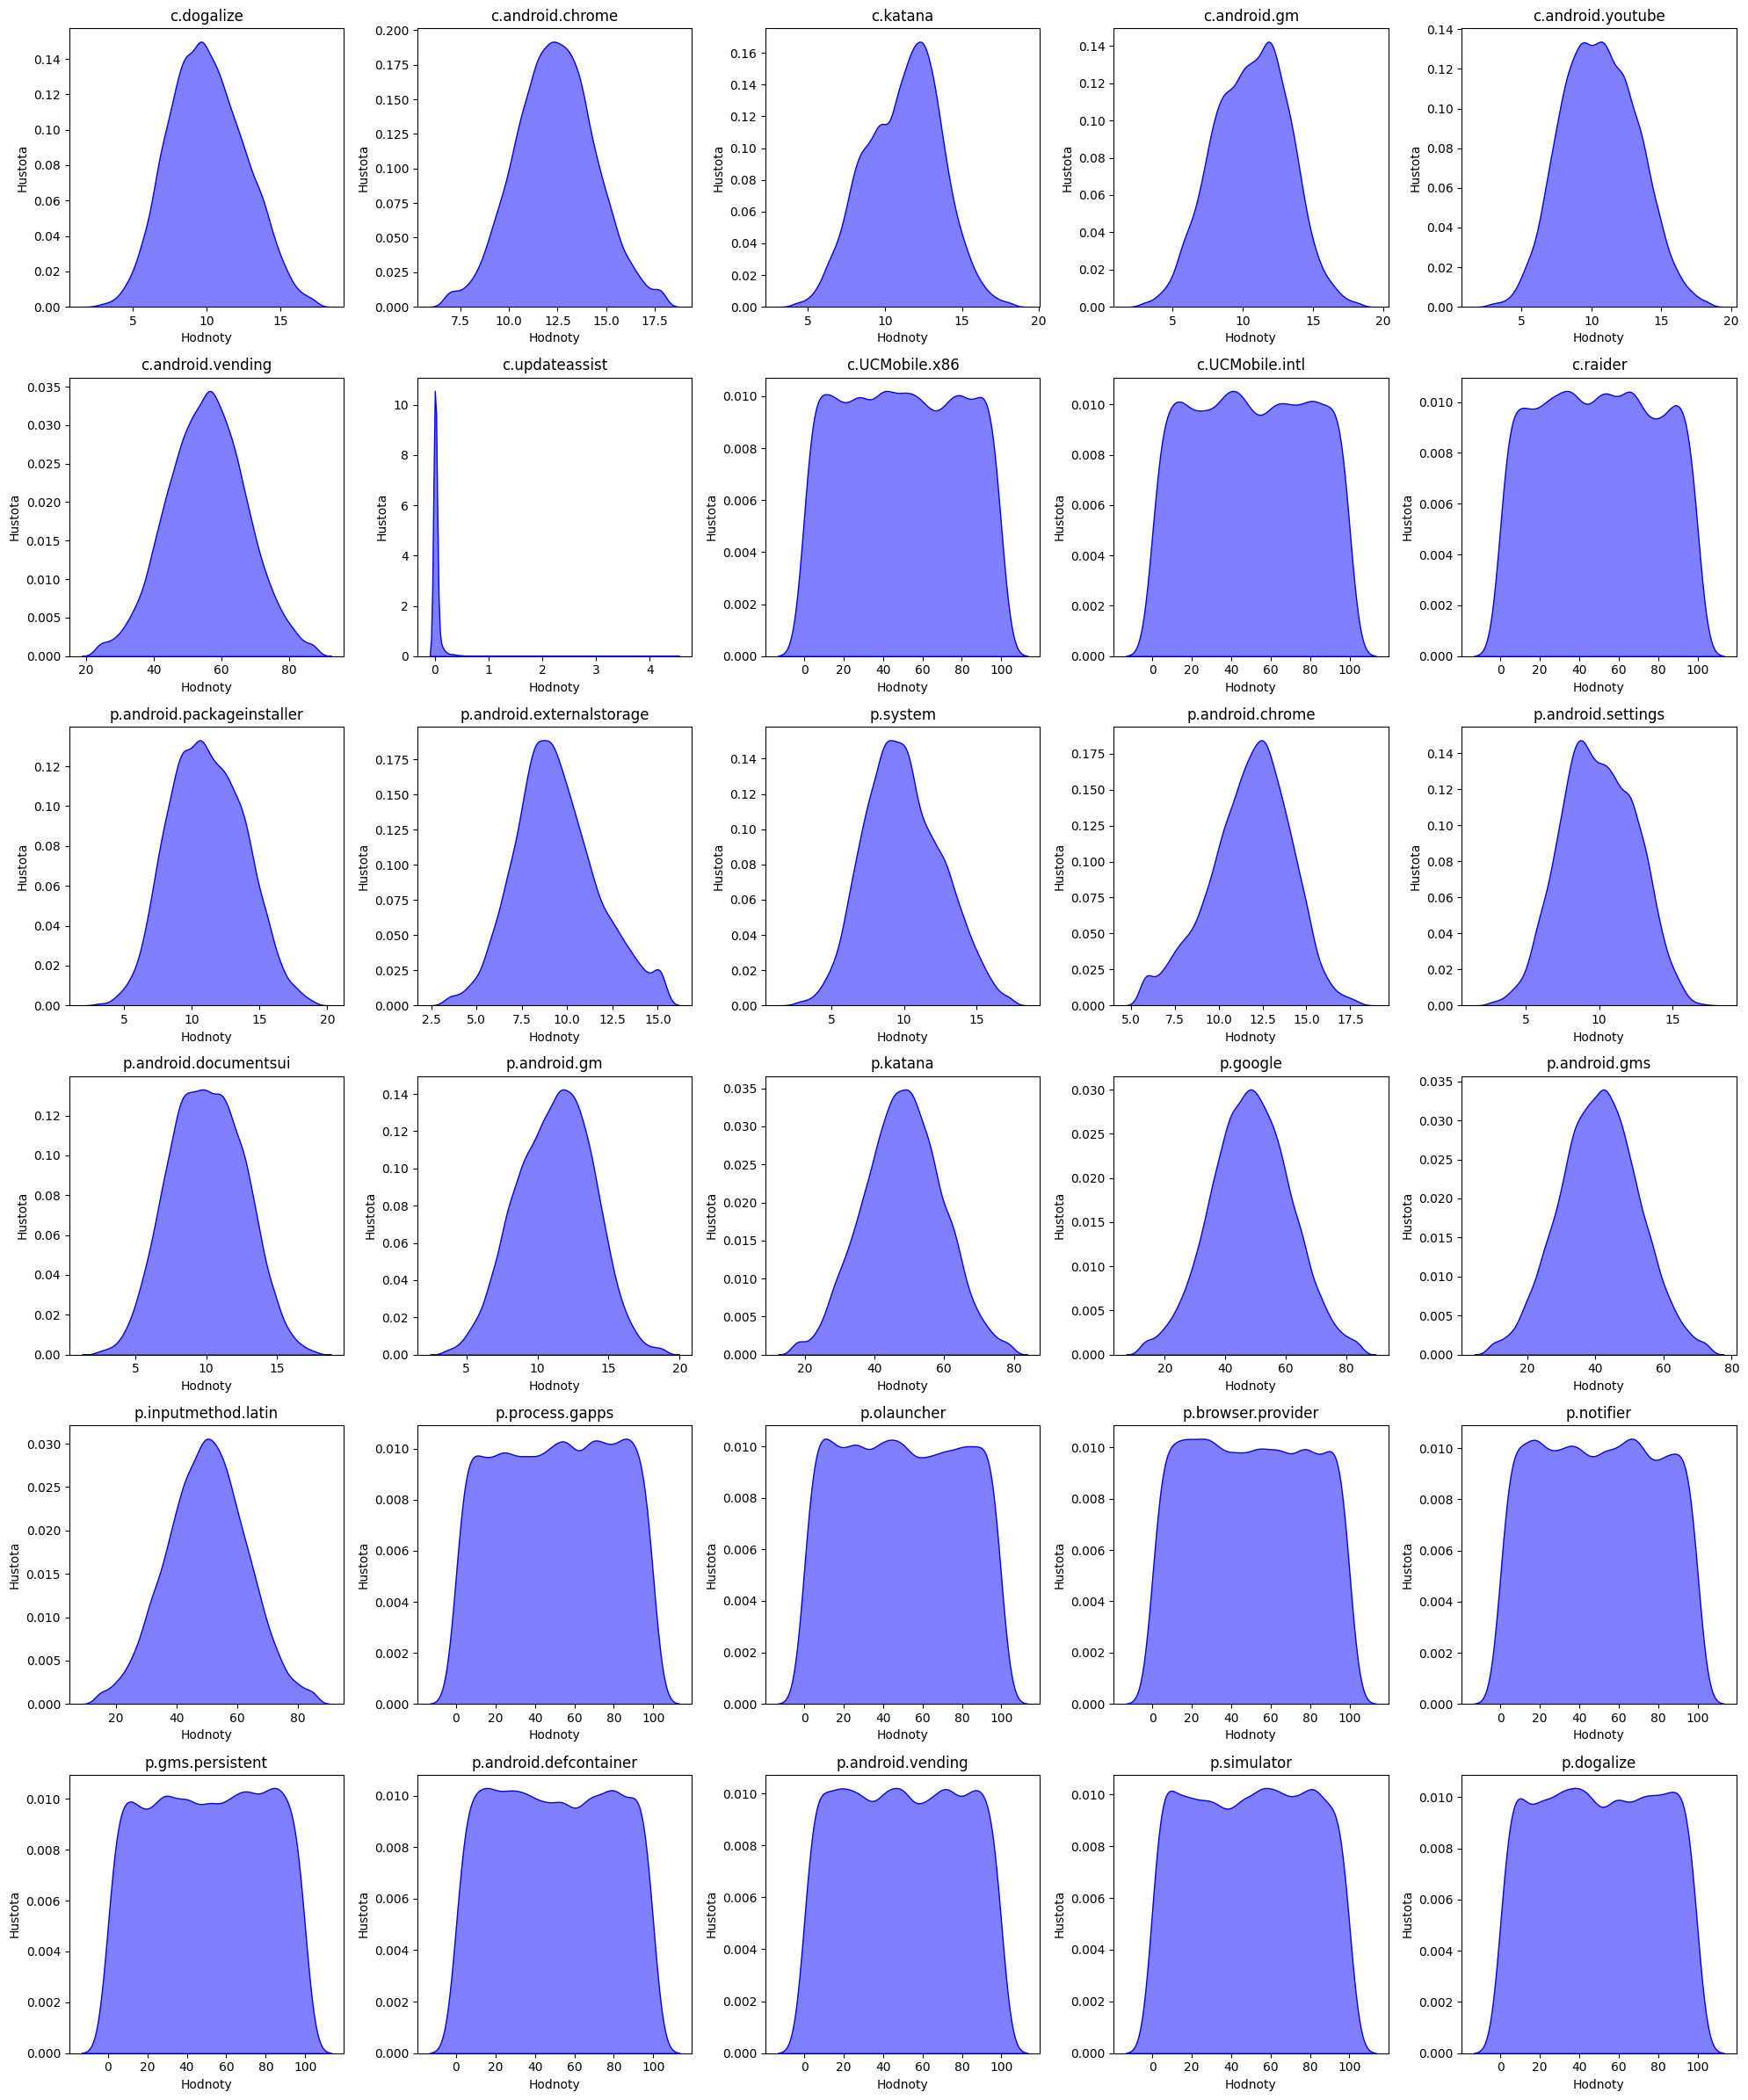

In [17]:
show_kde_graphs(X_train, X_train.columns)

#
### Najprv aplikujeme `Scaling`. Použijeme `StandardScaler`, `MinMaxScaler`, (`RobustScaler`).
#

### `StandardScaler`

In [18]:
standard_scaler = StandardScaler()
X_train_standard = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)

### Zobrazenie nových hodnôt.

In [19]:
X_train_standard.head()

,c.dogalize,c.android.chrome,c.katana,c.android.gm,c.android.youtube,c.android.vending,c.updateassist,c.UCMobile.x86,c.UCMobile.intl,c.raider,p.android.packageinstaller,p.android.externalstorage,p.system,p.android.chrome,p.android.settings,p.android.documentsui,p.android.gm,p.katana,p.google,p.android.gms,p.inputmethod.latin,p.process.gapps,p.olauncher,p.browser.provider,p.notifier,p.gms.persistent,p.android.defcontainer,p.android.vending,p.simulator,p.dogalize
0,-0.548265,0.178501,0.341937,-0.818420,0.200895,1.540449,-0.165156,-1.693730,0.516416,0.754976,0.486129,0.304816,1.629147,0.430096,-0.039845,-0.975688,1.245674,-0.295662,0.264099,0.974468,-0.013533,-0.063988,-0.632388,-0.816243,0.711588,0.397448,1.485039,1.659682,1.221151,-1.615228
1,0.104190,-0.531504,-0.726805,-0.153150,0.530067,-0.455336,-0.046996,-1.026431,1.697210,-1.037555,1.090776,0.712640,1.381250,-1.214629,-1.005329,0.735323,0.655602,0.284921,0.364880,-0.059299,-0.185009,-0.086783,-0.789039,1.158384,1.420571,-0.350588,0.019091,0.892991,-1.342679,0.784626
2,-0.690492,-0.290115,-1.764315,0.502848,0.410651,-0.410735,2.178924,1.661932,0.385460,-0.866613,2.118022,-0.640776,-0.481295,1.127951,1.385590,-1.239388,-0.387560,0.338806,0.096425,-0.648967,1.944358,-1.456252,-0.324555,-1.034811,-1.212412,0.369865,-1.670881,-0.780217,-0.128815,0.595865
3,1.262727,-0.455980,0.507349,-1.190043,-0.934151,-0.318175,-0.191947,1.677013,-0.448369,-0.837935,-0.570045,1.322203,-1.010708,0.837431,-0.269880,-0.546957,0.162705,-0.086023,-0.182621,1.973311,-0.667521,1.297023,0.075860,0.814126,1.056964,-0.088518,-1.702147,-1.698871,-0.605995,-1.058575
4,-0.216702,2.057790,0.910187,-1.536746,-0.317611,0.422462,-0.193099,0.029669,-0.618977,0.291992,-1.035629,-1.024891,0.313535,0.008295,-0.195837,-0.471468,0.384909,0.089000,-0.659509,-0.978960,1.072519,-1.114043,1.528552,0.424142,0.856141,-0.684241,0.010343,0.857526,-0.567790,-0.685845


### Zobrazenie deskriptívnych štatistík.

In [20]:
X_train_standard.describe().round(3)

,c.dogalize,c.android.chrome,c.katana,c.android.gm,c.android.youtube,c.android.vending,c.updateassist,c.UCMobile.x86,c.UCMobile.intl,c.raider,p.android.packageinstaller,p.android.externalstorage,p.system,p.android.chrome,p.android.settings,p.android.documentsui,p.android.gm,p.katana,p.google,p.android.gms,p.inputmethod.latin,p.process.gapps,p.olauncher,p.browser.provider,p.notifier,p.gms.persistent,p.android.defcontainer,p.android.vending,p.simulator,p.dogalize
count,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000
mean,-0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.861,-2.703,-2.897,-2.918,-2.912,-2.721,-0.194,-1.711,-1.741,-1.734,-2.953,-2.606,-2.840,-2.620,-2.953,-2.916,-2.866,-2.703,-2.694,-2.708,-2.702,-1.746,-1.710,-1.721,-1.720,-1.743,-1.721,-1.724,-1.707,-1.729
25%,-0.726,-0.681,-0.732,-0.734,-0.739,-0.684,-0.193,-0.861,-0.867,-0.852,-0.743,-0.677,-0.721,-0.626,-0.725,-0.729,-0.718,-0.673,-0.674,-0.678,-0.674,-0.869,-0.860,-0.867,-0.870,-0.857,-0.870,-0.877,-0.873,-0.862
50%,-0.059,-0.001,0.089,0.037,-0.025,0.011,-0.187,-0.009,-0.016,0.002,-0.043,-0.095,-0.072,0.093,-0.028,-0.013,0.044,0.004,-0.002,0.007,0.009,0.017,-0.015,-0.002,0.006,0.009,-0.001,-0.005,0.014,-0.012
75%,0.696,0.665,0.710,0.721,0.711,0.675,-0.139,0.874,0.870,0.850,0.728,0.606,0.692,0.702,0.760,0.728,0.715,0.680,0.673,0.676,0.678,0.865,0.871,0.871,0.853,0.869,0.879,0.868,0.869,0.873
max,2.829,2.684,2.873,2.905,2.886,2.713,21.189,1.734,1.729,1.749,2.929,2.539,2.813,2.695,2.989,2.914,2.864,2.710,2.692,2.707,2.707,1.718,1.739,1.735,1.737,1.723,1.728,1.731,1.731,1.736


### Použitím `.describe` vidíme, že `mean = 0` a `std = 1`, tak ako sa predpokladalo.

### Pre lepšie porovnanie a vizualizáciu, zobrazíme atribúty na `Box-plote`.

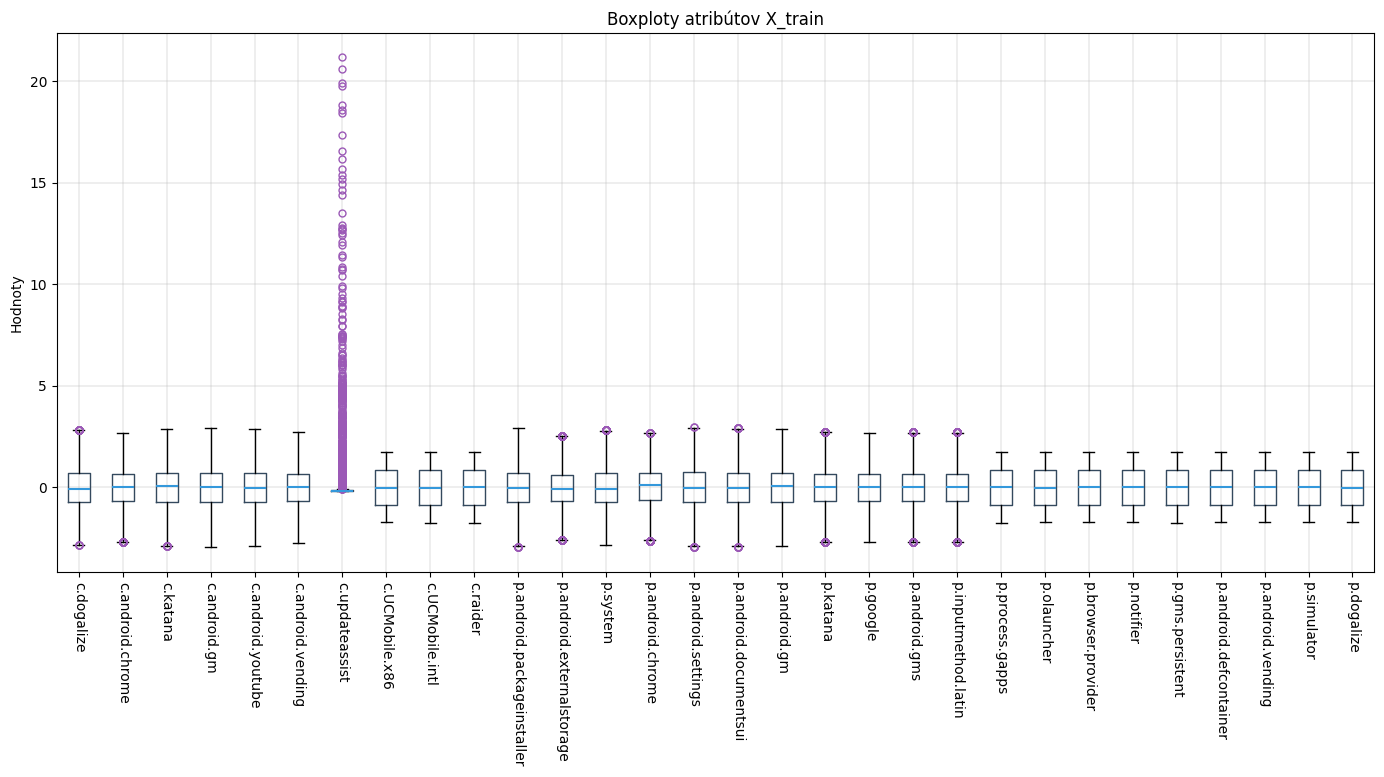

In [21]:
show_boxplots(X_train_standard)

### Vidíme, že rozsahy atribútov sú približne na rovnakej úrovni, čo bol náš cieľ. Atribút `c.updateassist` je jedinou výnimkou, pretože už vo fáze `EDA` sme k jeho outlierom pristupovali odlišne.

#
### `MinMaxScaler`

In [22]:
minmax_scaler = MinMaxScaler(feature_range=(0.1, 1.1))
X_train_minmax = pd.DataFrame(minmax_scaler.fit_transform(X_train), columns=X_train.columns)

### Zobrazenie nových hodnôt.

In [23]:
X_train_minmax.head()

,c.dogalize,c.android.chrome,c.katana,c.android.gm,c.android.youtube,c.android.vending,c.updateassist,c.UCMobile.x86,c.UCMobile.intl,c.raider,p.android.packageinstaller,p.android.externalstorage,p.system,p.android.chrome,p.android.settings,p.android.documentsui,p.android.gm,p.katana,p.google,p.android.gms,p.inputmethod.latin,p.process.gapps,p.olauncher,p.browser.provider,p.notifier,p.gms.persistent,p.android.defcontainer,p.android.vending,p.simulator,p.dogalize
0,0.506385,0.634929,0.661374,0.460566,0.636887,0.884246,0.101336,0.105044,0.750541,0.814639,0.684696,0.665737,0.890629,0.673858,0.590240,0.432850,0.817618,0.544770,0.649196,0.780039,0.597034,0.585667,0.412471,0.361776,0.803415,0.717560,1.029614,1.079263,0.951657,0.132711
1,0.621055,0.503123,0.476132,0.574822,0.693659,0.516919,0.106862,0.298758,1.090867,0.299963,0.787485,0.744999,0.846773,0.364377,0.427752,0.726295,0.714638,0.652031,0.667909,0.589133,0.565331,0.579086,0.367048,0.933212,1.008516,0.501752,0.604538,0.857408,0.205923,0.825479
2,0.481388,0.547934,0.296303,0.687486,0.673064,0.525127,0.210961,1.079181,0.712797,0.349044,0.962117,0.481957,0.517269,0.805170,0.830136,0.387624,0.532585,0.661986,0.618063,0.480238,0.959012,0.183711,0.501732,0.298524,0.246826,0.709602,0.114502,0.373236,0.558996,0.770989
3,0.824670,0.517143,0.690044,0.396742,0.441126,0.542163,0.100083,1.083559,0.472473,0.357279,0.505146,0.863470,0.423610,0.750504,0.551526,0.506379,0.628618,0.583500,0.566252,0.964495,0.476124,0.978601,0.617839,0.833587,0.903328,0.577359,0.105436,0.107408,0.420200,0.293401
4,0.564658,0.983803,0.759867,0.337198,0.547461,0.678479,0.100029,0.605341,0.423300,0.681705,0.425997,0.407303,0.657883,0.594490,0.563987,0.519326,0.667397,0.615835,0.477705,0.419298,0.797825,0.282509,1.039070,0.720730,0.845233,0.405493,0.602001,0.847145,0.431313,0.400997


### Zobrazenie deskriptívnych štatistík.

In [24]:
X_train_minmax.describe().round(3)

,c.dogalize,c.android.chrome,c.katana,c.android.gm,c.android.youtube,c.android.vending,c.updateassist,c.UCMobile.x86,c.UCMobile.intl,c.raider,p.android.packageinstaller,p.android.externalstorage,p.system,p.android.chrome,p.android.settings,p.android.documentsui,p.android.gm,p.katana,p.google,p.android.gms,p.inputmethod.latin,p.process.gapps,p.olauncher,p.browser.provider,p.notifier,p.gms.persistent,p.android.defcontainer,p.android.vending,p.simulator,p.dogalize
count,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000,11968.000
mean,0.603,0.602,0.602,0.601,0.602,0.601,0.109,0.597,0.602,0.598,0.602,0.606,0.602,0.593,0.597,0.600,0.600,0.599,0.600,0.600,0.600,0.604,0.596,0.598,0.598,0.603,0.599,0.599,0.596,0.599
std,0.176,0.186,0.173,0.172,0.172,0.184,0.047,0.290,0.288,0.287,0.170,0.194,0.177,0.188,0.168,0.172,0.175,0.185,0.186,0.185,0.185,0.289,0.290,0.289,0.289,0.289,0.290,0.289,0.291,0.289
min,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100,0.100
25%,0.475,0.475,0.475,0.475,0.475,0.475,0.100,0.347,0.352,0.353,0.476,0.475,0.475,0.475,0.475,0.475,0.475,0.475,0.475,0.475,0.475,0.353,0.346,0.347,0.346,0.356,0.347,0.345,0.343,0.350
50%,0.592,0.602,0.618,0.607,0.598,0.603,0.100,0.594,0.597,0.598,0.595,0.588,0.590,0.610,0.592,0.598,0.608,0.600,0.600,0.601,0.601,0.609,0.592,0.597,0.599,0.606,0.599,0.597,0.601,0.596
75%,0.725,0.725,0.725,0.725,0.725,0.725,0.103,0.850,0.852,0.842,0.726,0.724,0.725,0.725,0.725,0.725,0.725,0.725,0.725,0.725,0.725,0.854,0.848,0.850,0.844,0.853,0.854,0.850,0.849,0.851
max,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100,1.100


### Vidíme, že `mean` je hodnota blízka `0.5`, čo opäť vychádza z toho, že sme použili rozsah `(0.1 - 1.1)`.

### Pre lepšie porovnanie a vizualizáciu, zobrazíme atribúty na `Box-plote`.

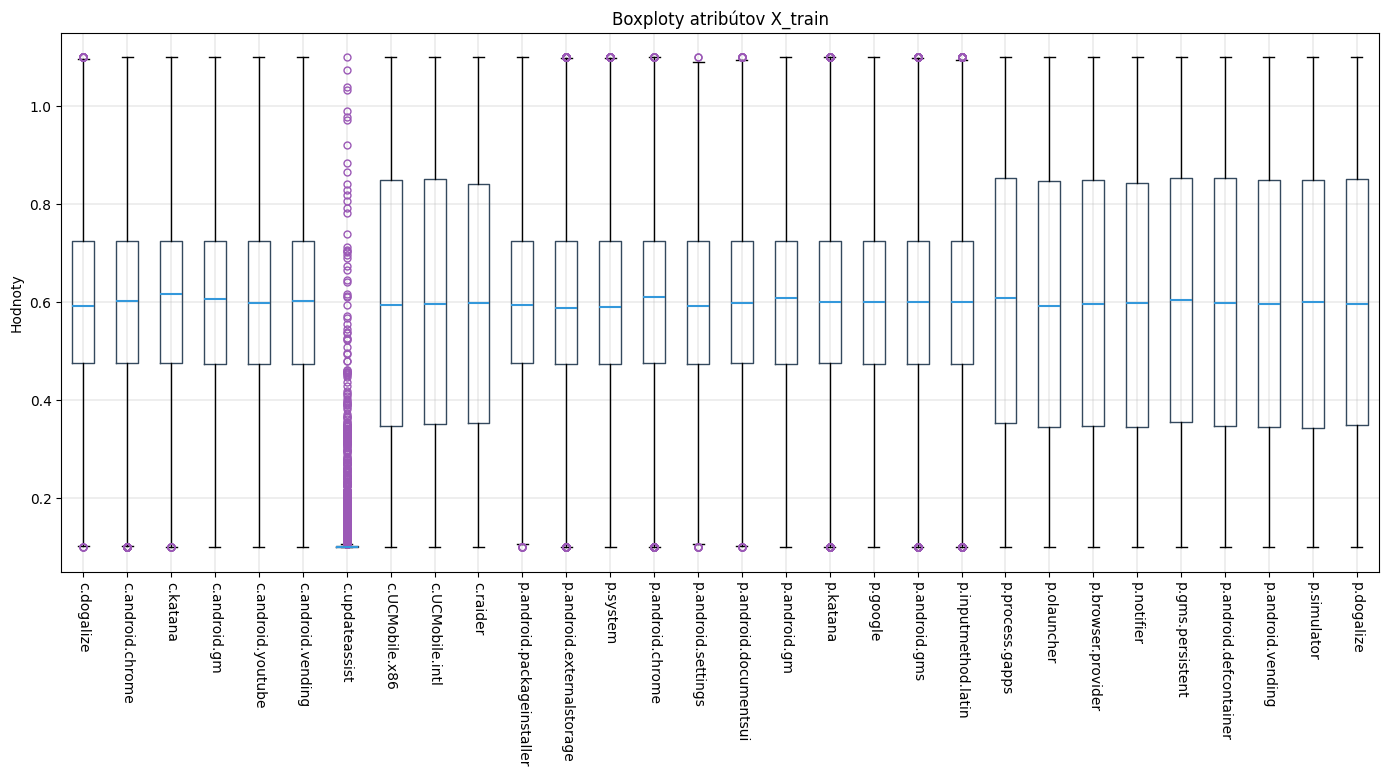

In [25]:
show_boxplots(X_train_minmax)

### Vidíme, že rozsah je naozaj `(0.1 - 1.1)`, pre všetky atribúty.

#
### `RobustScaler`

In [26]:
robust_scaler = RobustScaler()
robusted = pd.DataFrame(robust_scaler.fit_transform(X_train), columns=X_train.columns)

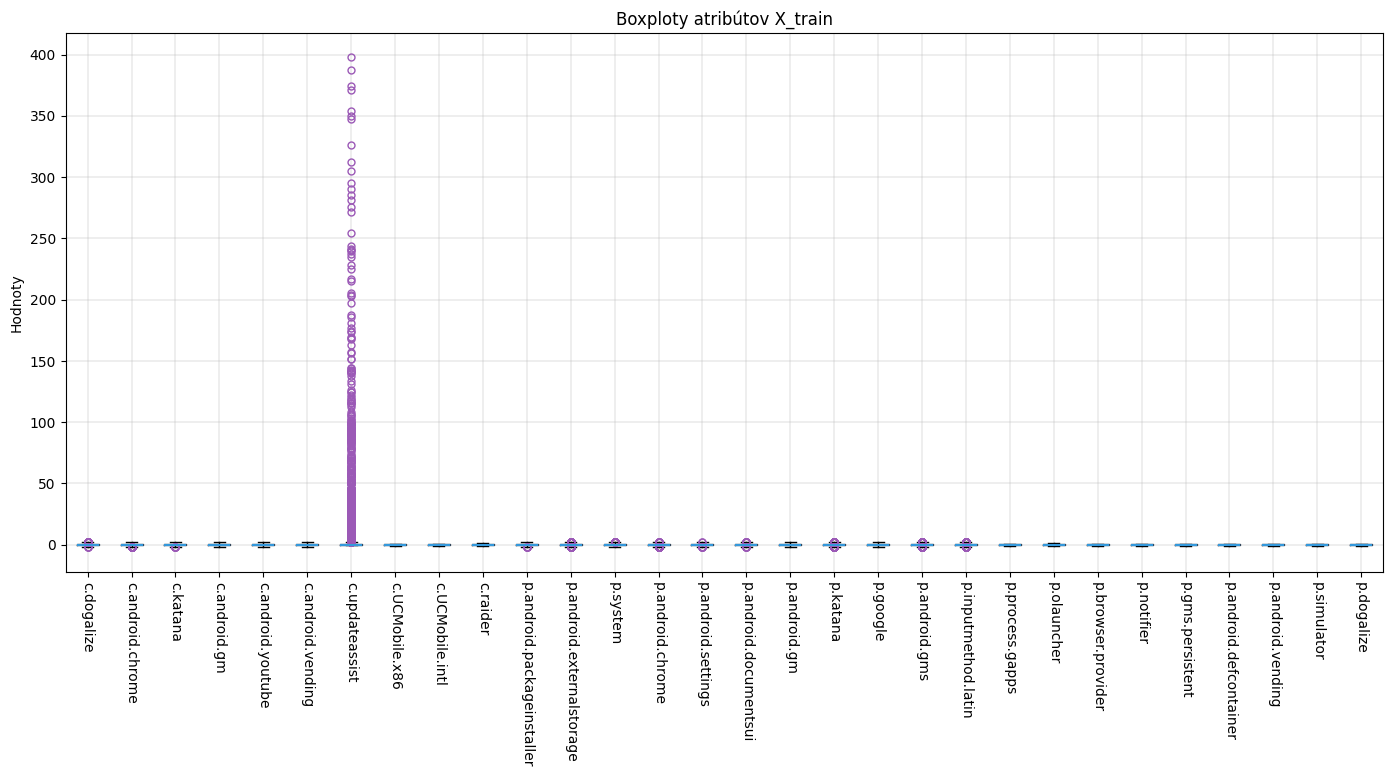

In [27]:
show_boxplots(robusted)

### Vyskúšali sme aj `RobustScaler`. Vidíme však, že rozsah je veľmi blízko `0`, respektíve `0`.

#
### `Fukcia:` Podľa `Shapiro-Wilk testu` vyberieme atribúty na ktoré aplikujeme transformácie.

In [28]:
def check_normality(df, sample_size):
    sample_size = min(sample_size, len(df))
    
    df_sample = df.sample(n=sample_size, random_state=17)

    normal_columns = []

    for column in df_sample.columns:
        # Shapiro-Wilk test
        _, p_shapiro = shapiro(df_sample[column])
        if p_shapiro > 0.05:
            normal_columns.append(column)

    return normal_columns


### Atribúty spadajúce do normálnej distribúcie podľa `S-W testu` pre vzorku veľksti `sample_size`.

In [29]:
normal_columns = check_normality(df=X_train_standard, sample_size=1000)
normal_columns

['c.android.chrome',
 'c.android.youtube',
 'c.android.vending',
 'p.android.gm',
 'p.katana',
 'p.google',
 'p.android.gms',
 'p.inputmethod.latin']

### Takisto uložíme atribúty, ktoré podľa nás spadajú do normálnej distribúcie.

In [30]:
our_normal_columns = ['c.dogalize', 'c.android.chrome', 'c.android.youtube', 'c.android.vending',
                      'p.android.packageinstaller', 'p.system', 'p.android.documentsui', 'p.android.gm',
                      'p.katana', 'p.google', 'p.android.gms', 'p.inputmethod.latin']

### Zobrazíme atribúty, ktoré podľa nás patria do normálnej distribúcie, no `Shapiro-Wilk test` ich nevybral.

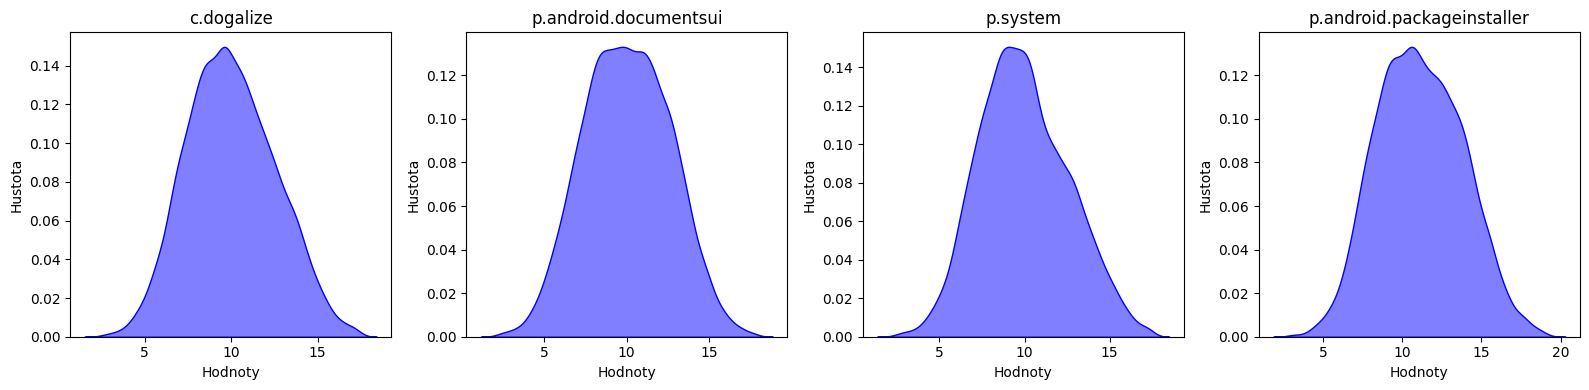

In [31]:
extra_in_our_choice = list(set(our_normal_columns) - set(normal_columns));
show_kde_graphs(X_train, extra_in_our_choice)

### Zobrazíme atribúty, ktoré `Shapiro-Wilk test` vybral, ale my nie, ako normálnu distribúciu.

In [32]:
extra_in_sw_choice = list(set(normal_columns) - set(our_normal_columns))
show_kde_graphs(X_train, extra_in_sw_choice)

No attributes to show


### Je tu malá nezhoda, pretože `náš` a `S-W test` výber sa nezhodujú úplne. Je to v poriadku, pretože my sme hodnotili distribúciu zo všetkých záznamov, no `S-W test` len zo vzorky `sample_size`. Transformovať budeme atribúty, podľa výsledkov z `S-W testu`. Použijeme teda transformácie aj na tie atribúty, ktoré sme my usúdili za normálne distribuované. Budeme ich potom schopný porovnať s netransformovanými, ktoré máme teraz.

### Atribúty, ktoré sa majú transformovať podľa výsledkov `Shapiro-Wilk` testu.

In [33]:
final_attributes = [col for col in X_train.columns if col not in normal_columns]

#
### `Funkcia:` Porovnanie atribútov pred a po transformácií.

In [34]:
def compare_kde_graphs(df1, df1_name, df2, df2_name, attributes):
    num_attributes = len(attributes)

    if num_attributes == 0:
        print("No attributes to show")
        return
    
    rows = math.ceil(num_attributes / 2)
    cols = 4

    plt.figure(figsize=(cols * 3, rows * 2))

    for i in range(num_attributes):
        plt.subplot(rows, cols, i * 2 + 1)
        sns.kdeplot(df1[attributes[i]], fill=True, color='blue', alpha=0.5)
        plt.title(f'{df1_name} | {attributes[i]}', fontsize=8)
        plt.xlabel('Hodnoty')
        plt.ylabel('Hustota')

        plt.subplot(rows, cols, i * 2 + 2)
        sns.kdeplot(df2[attributes[i]], fill=True, color='#3498DB', alpha=0.5)
        plt.title(f'{df2_name} | {attributes[i]}', fontsize=8)
        plt.xlabel('Hodnoty')
        plt.ylabel('Hustota')

    plt.subplots_adjust(hspace=1.5, wspace=0.4)

    plt.tight_layout()
    plt.show()

### `Funkcia:` Aplikovanie transformácie `method` na atribúty `columns`.

In [35]:
def apply_power_transform(df, columns, method):
    transformed_data = df.copy()
    
    if method == 'box-cox':
        pt = PowerTransformer(method='box-cox')
        transformed_data[columns] = pt.fit_transform(transformed_data[columns])
    elif method == 'yeo-johnson':
        pt = PowerTransformer(method='yeo-johnson')
        transformed_data[columns] = pt.fit_transform(transformed_data[columns])
    else:
        print("Unknown method. Type 'box-cox' or 'yeo-johnson'.")
        return None

    return transformed_data

#
### `Transformácie`, ktoré použijeme sú: `Box-Cox`, `Yeo-Johnson` a `Logaritmická` transformácia.

#
### `Box-Cox`

### Keďže transformácia `Box-Cox` pracuje len s kladnými hodnotami, aplikujeme ju len na DF, kde sme použili `MinMaxScaler`, pretože `StandardScaler` dá aj záporné hodnoty.

#### `Box-Cox` na DF s `MinMaxScaler`.

In [36]:
X_train_minmax_boxcox = apply_power_transform(df=X_train_minmax, columns=final_attributes, method='box-cox')

### Porovnanie distribúcií atribútov po aplikovaní `Box-Cox` transformácie.

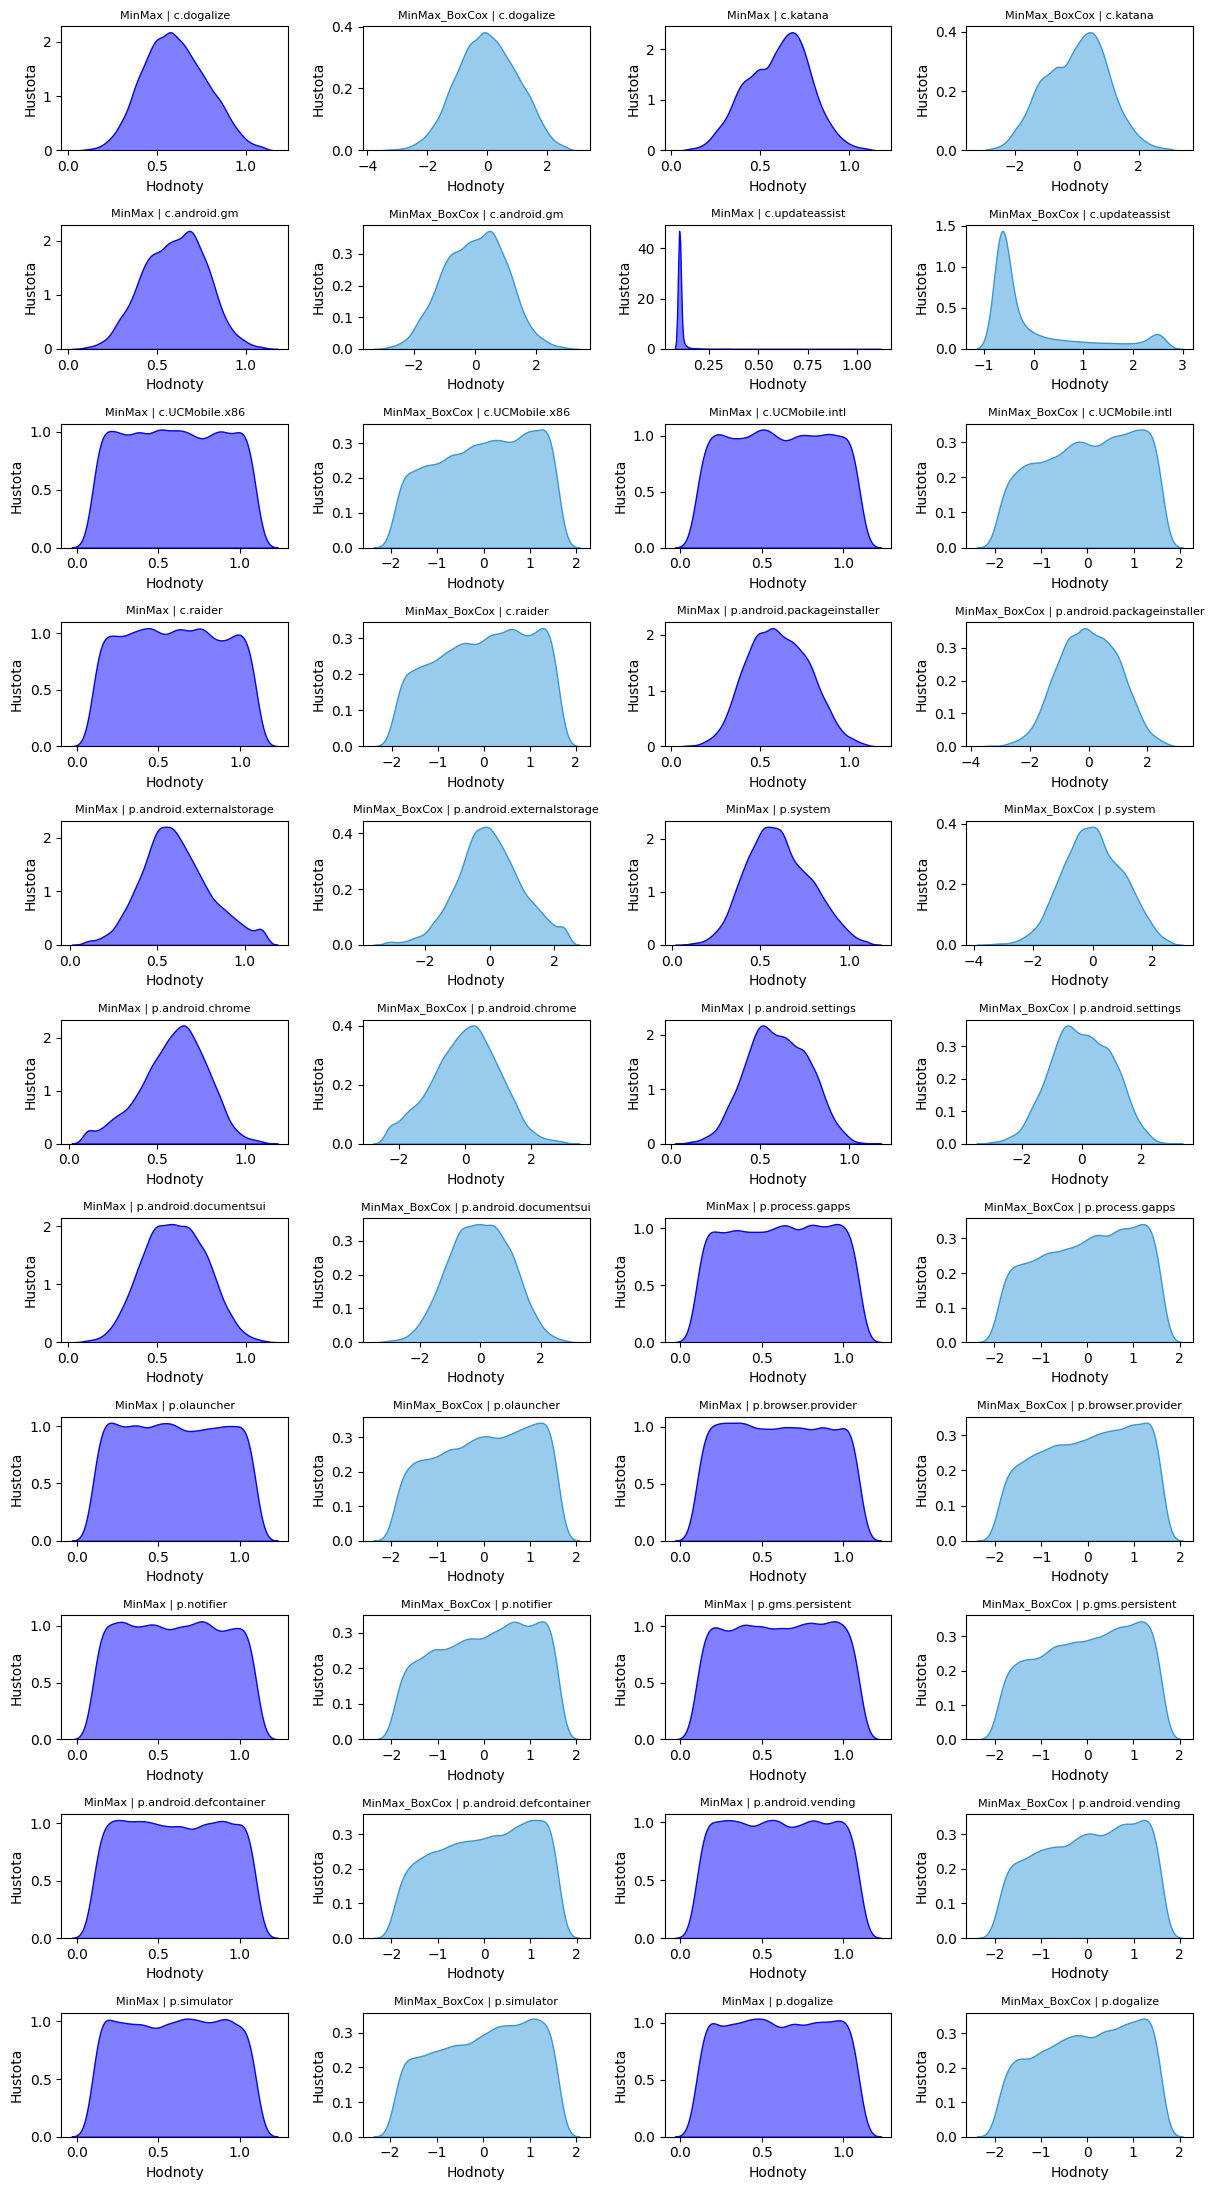

In [37]:
compare_kde_graphs(df1=X_train_minmax, df1_name="MinMax", df2=X_train_minmax_boxcox, df2_name="MinMax_BoxCox", attributes=final_attributes)

### Môžeme vidieť, že distribúcie atribútov, ktorých distribúcia pred tranformáciou bolo približne normálna, sa výrazne nezmenila. Na druhej strane, atribúty s distribúciou uniformnou sa zmenili na "`skewed`" distribúciu. 

#
### `Yeo-Johnson`

### Túto transformáciu použijeme na `DFs`, kde sme už aplikovali `StandardScaler` a aj `MinMaxScaler`.

#### `Yeo-Johnson` na DF s `StandardScaler`.

In [38]:
X_train_standard_yeo = apply_power_transform(df=X_train_standard, columns=final_attributes, method="yeo-johnson")

### Porovnanie distribúcií atribútov po aplikovaní `Yeo-Johnson` transformácie.

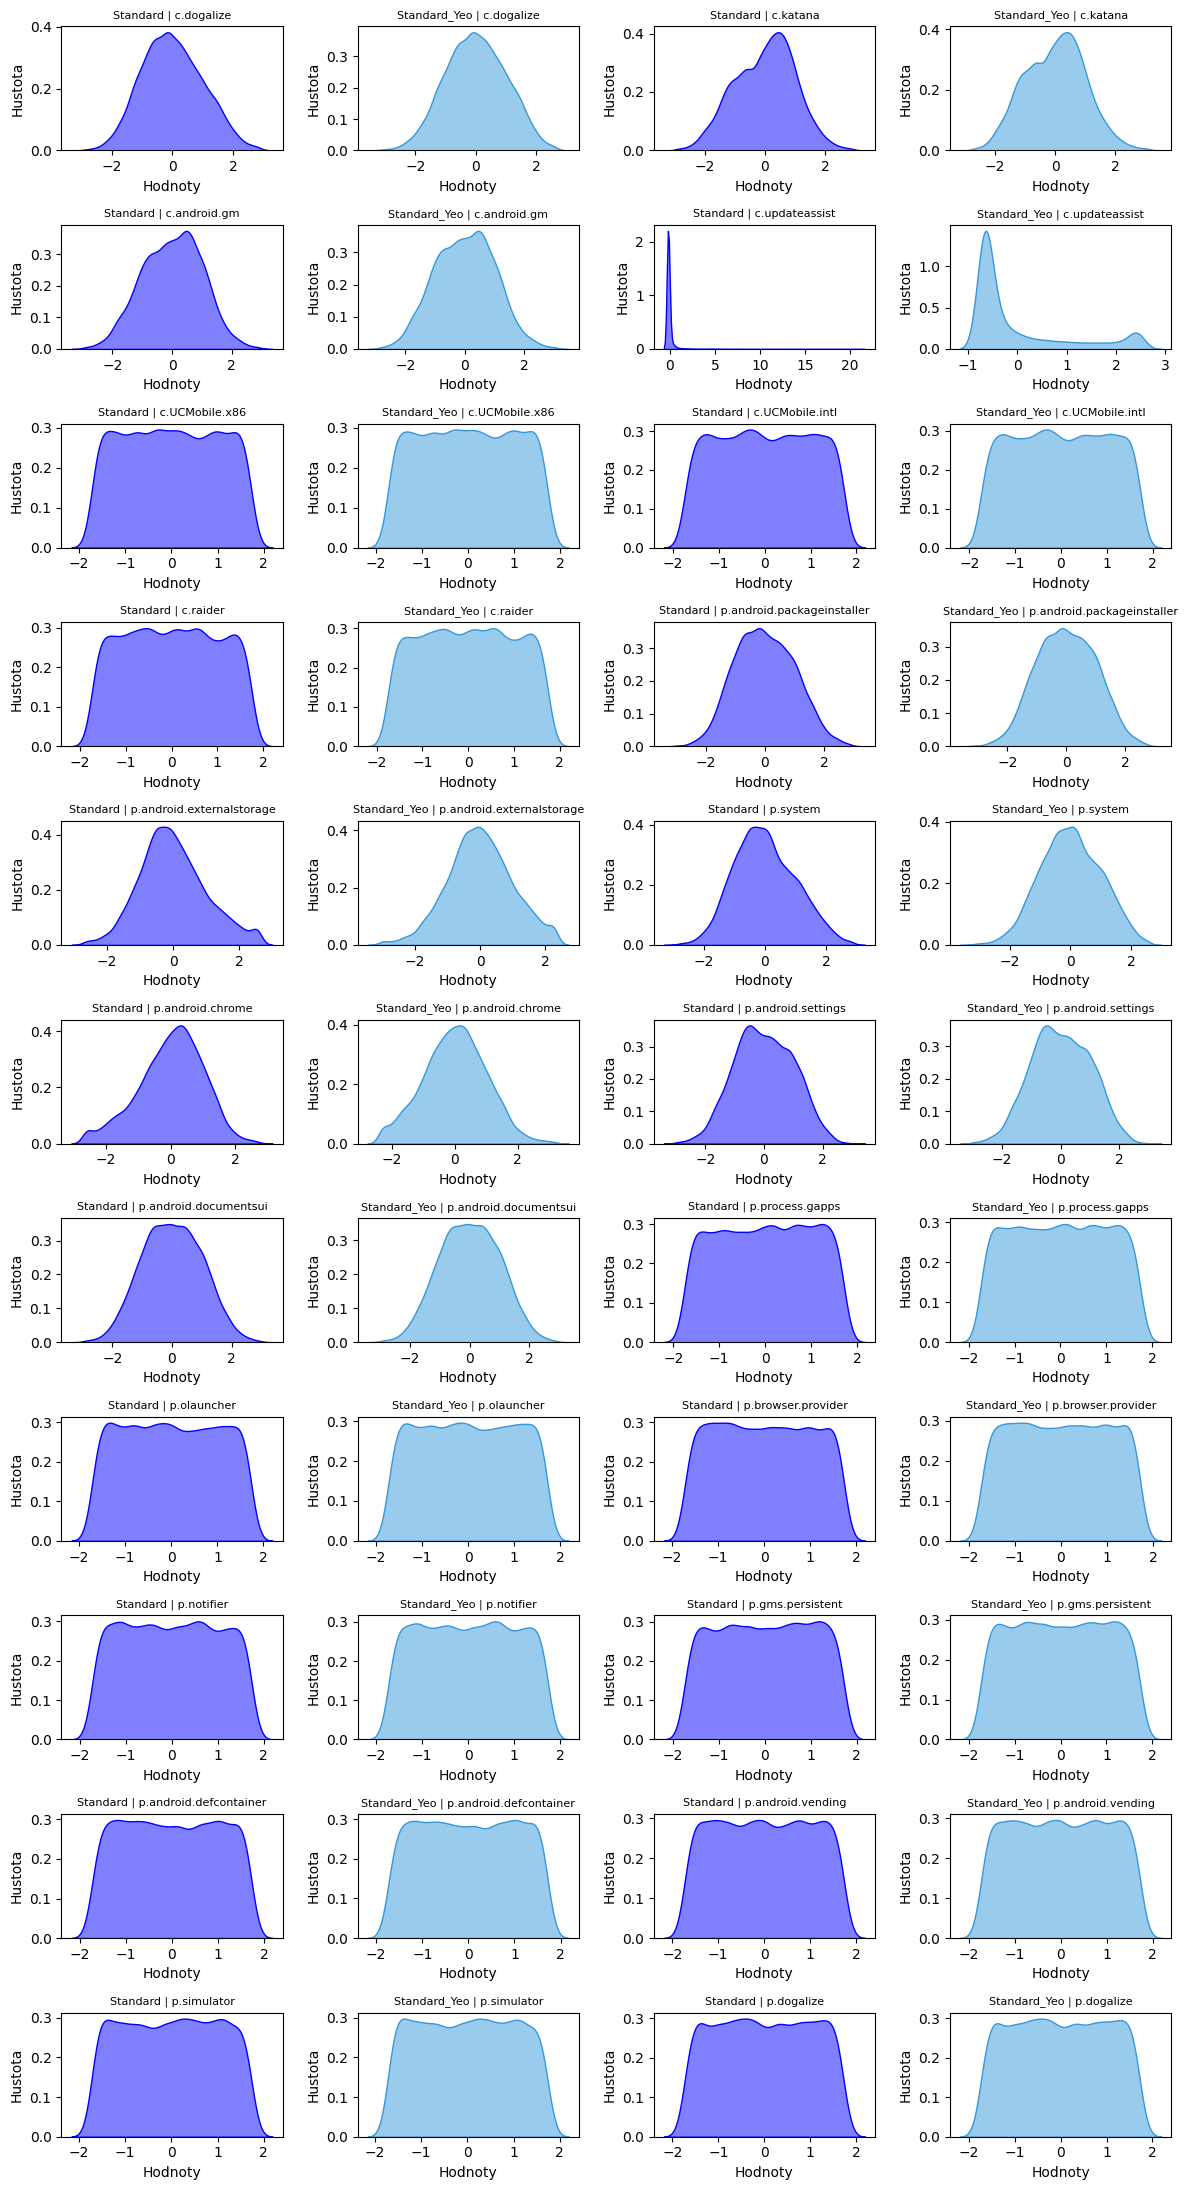

In [39]:
compare_kde_graphs(df1=X_train_standard, df1_name="Standard", df2=X_train_standard_yeo, df2_name="Standard_Yeo", attributes=final_attributes)

### Z grafov vidíme, že sa distribúcie výrazne nemenili. Jedna, na oko malá, zmena je však, že distribúcia sa stala ešte viac uniformou pre atribút `p.gms.persistent`.

#
#### `Yeo-Johnson` na DF s `MinMaxScaler`.

In [40]:
X_train_minmax_yeo = apply_power_transform(df=X_train_minmax, columns=final_attributes, method="yeo-johnson")

### Porovnanie distribúcií atribútov po aplikovaní `Yeo-Johnson` transformácie.

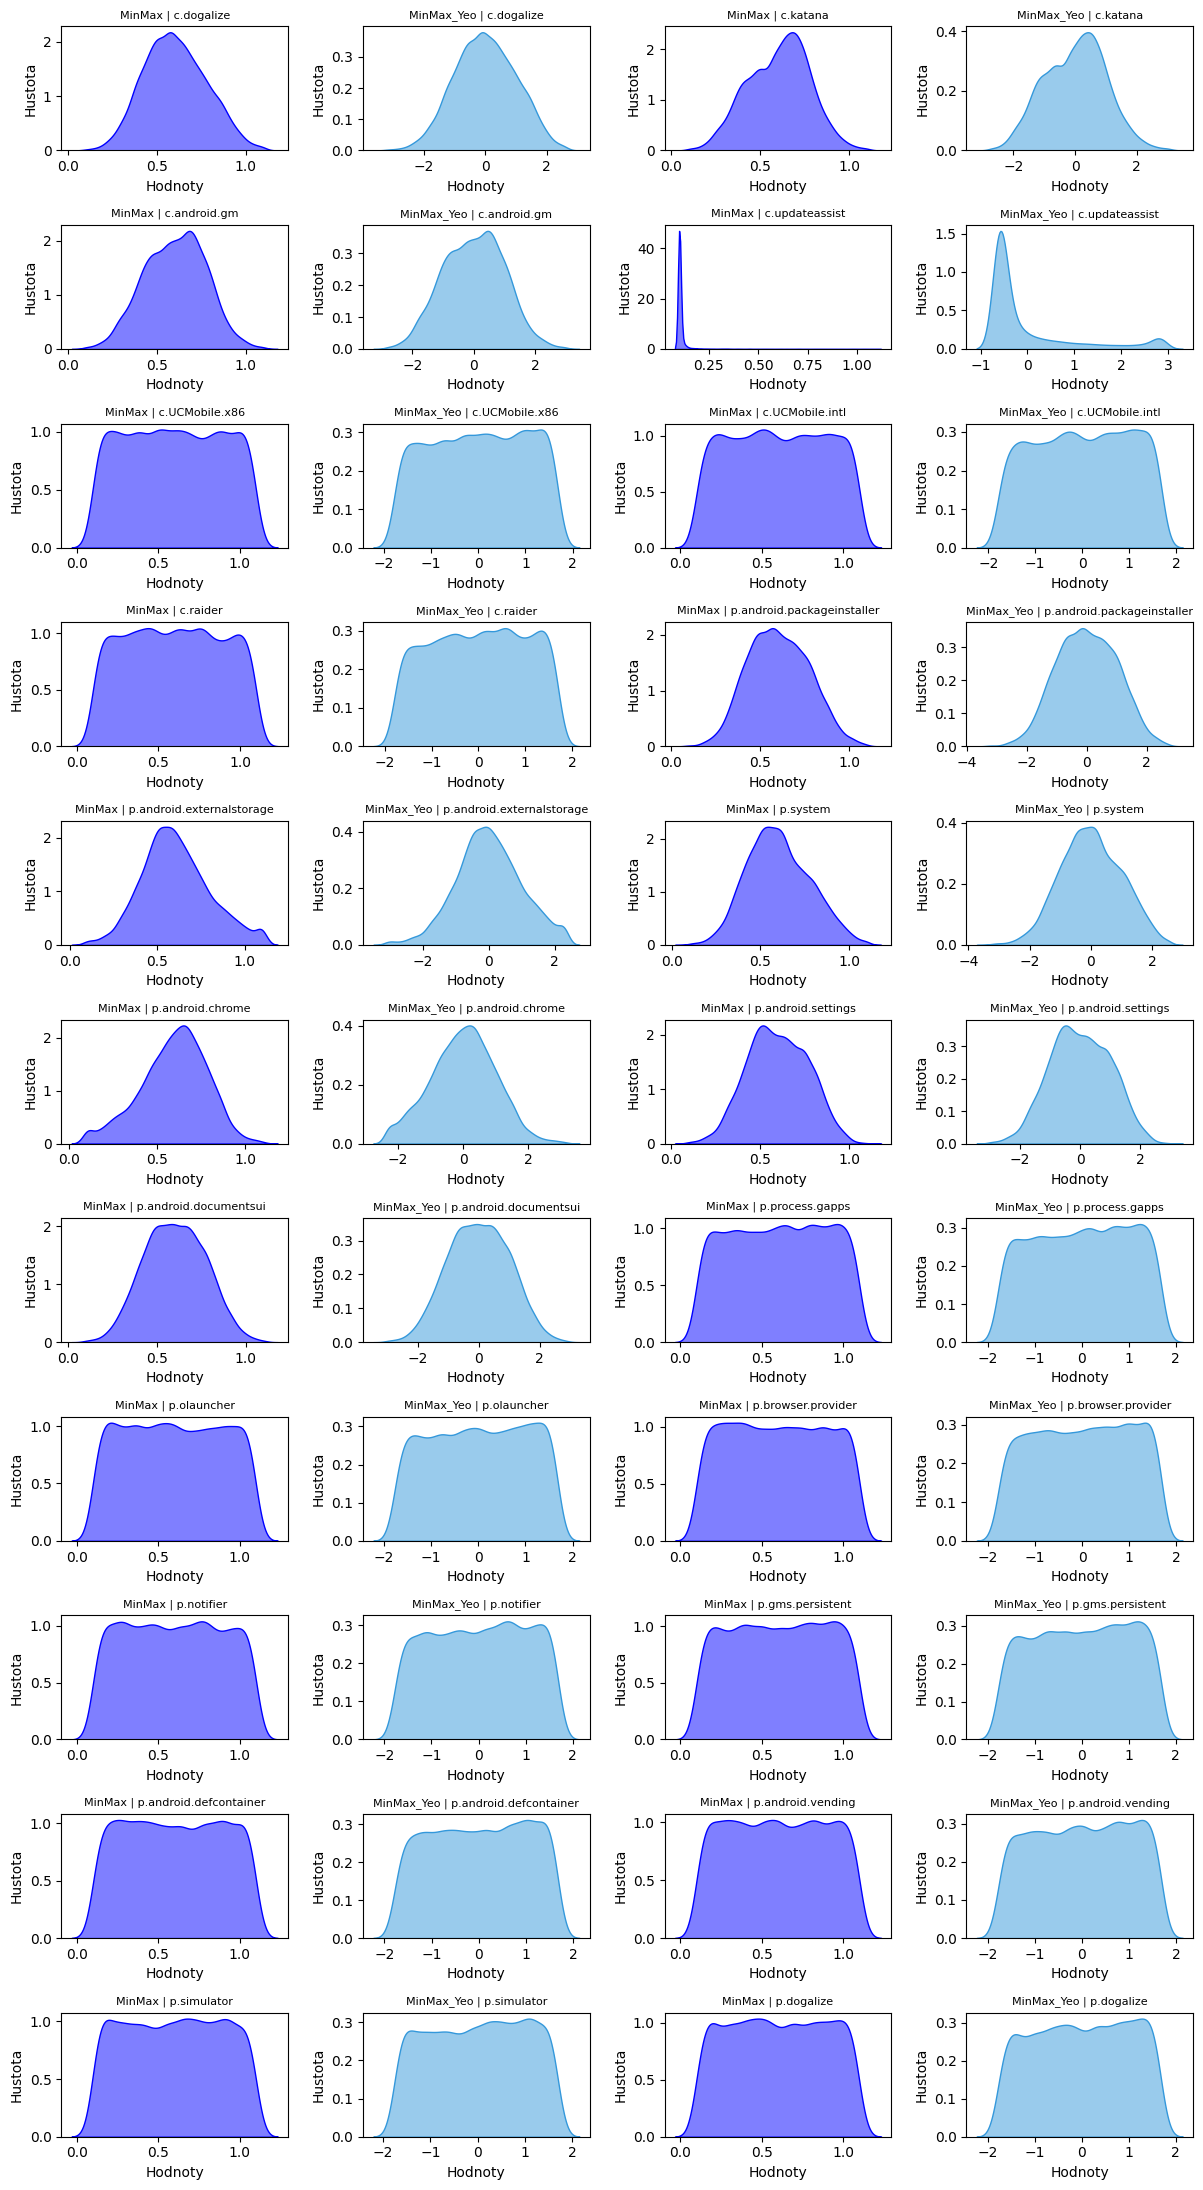

In [41]:
compare_kde_graphs(df1=X_train_minmax, df1_name="MinMax", df2=X_train_minmax_yeo, df2_name="MinMax_Yeo", attributes=final_attributes)

### Môžeme vidieť, že už "relatívne" normálne distribúcie pred aplikovaním transformácie sa len jemne "znormálnili". Jasne viditeľné je však, že uniformné distribúcie sa jemne, negatívne naklonili.

## *D) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu.*

### Použili sme 2 techniky `Scaling`: `StandardScaler` a `MinMaxScaler`. Obidve techniky splnili svoj účel a jednotlivé atribúty zoškálovali do nastavených rozsahov. `RobustScaler` sme vyskúšali takisto, no nevyhovoval nám, čo sme opísali vyššie.
### Použili sme 2 techniky `Transformácie`: `Box-Cox` a `Yeo-Johnson`. Transformácie sme aplikovali na už škálované dáta. `Box-Cox` transformáciu sme použili len na dáta, kde sme aplikovali `MinMaxScaler` (vyžaduje len kladné hodnoty; opísané vyššie).

#
# **2.2 Výber atribútov pre strojové učenie**

### `Funkcia:` Porovnanie `score` najlepších `features`.

In [42]:
def compare_feature_scores(attributes, score, selection):
    after_attributes, after_score = attributes, score
    if selection != "RFE":
        lists_after_sort = sorted(zip(score, attributes), key=lambda x: abs(x[0]), reverse=True)
        after_score, after_attributes = zip(*lists_after_sort)
    
    after_score = [abs(s) for s in after_score]

    plt.figure(figsize=(8, 5))
    plt.bar(after_attributes, after_score, color='#9B59B6')
    plt.xlabel("Feature")
    plt.ylabel("Score")
    plt.title(f"Selection: {selection}")
    plt.xticks(rotation=270)
    plt.tight_layout()
    plt.show()

## *A) Zistite, ktoré atribúty sú informatívne k predikovanej premennej.*

### Atribúty, ktoré sú najviac informatívne k predikovanej premennej budeme zisťovať z viacerých DF, pre porovnanie. Keďže v `pipeline` budeme používať aj `Scaling`, aj `Transformáciu`, týmto porovnaním zistíme rozdiely medzi jednotlivými možnosťami, čo môže ovplyvniť náš výber do `pipeline`.

#
### Feature selection: `Chi-squared`.
#### Len kladné hodnoty.

#### `Funkcia:` Aplikovanie `Chi2-squared` selection na `df`.

In [43]:
def apply_selection_chi2(df):
    selector_chi2 = SelectKBest(score_func=chi2, k=10)
    selector_chi2.fit_transform(df, y_train)

    selected_features_chi2 = selector_chi2.get_support()

    chi2_names = df.columns[selected_features_chi2]
    chi2_scores = selector_chi2.scores_[selected_features_chi2]

    print(f"{'Feature':<29}  {'Score'}\n")
    for feature, coef in zip(chi2_names, chi2_scores):
        print(f"{feature:<29}  {coef}")
    
    return chi2_names, chi2_scores

#### `MinMax`

In [44]:
chi2_minmax_features, chi2_minmax_scores = apply_selection_chi2(df=X_train_minmax)

Feature                        Score

c.dogalize                     188.5511087264128
c.katana                       52.794063870932945
c.updateassist                 2.640160304360981
p.android.packageinstaller     161.0533787222086
p.android.externalstorage      75.97934762258271
p.system                       50.68492090704595
p.android.chrome               65.49445114303253
p.android.settings             49.56138772433718
p.android.documentsui          173.88927277102465
p.android.gm                   46.93192573096272


#
### Feature selection: `ANOVA`.

#### `Funkcia:` Aplikovanie `ANOVA` selection na `df`.

In [45]:
def apply_selection_anova(df):
    selector_anova = SelectKBest(score_func=f_classif, k=10)
    
    selector_anova.fit_transform(df, y_train.values.ravel())
    #anova_df = selector_anova.fit_transform(df, y_train.values.ravel())

    selected_features_anova = selector_anova.get_support()

    anova_names = df.columns[selected_features_anova]
    anova_scores = selector_anova.scores_[selected_features_anova]

    print(f"{'Feature':<29}  {'Score'}\n")
    for feature, coef in zip(anova_names, anova_scores):
        print(f"{feature:<29}  {coef}")

    return anova_names, anova_scores

#### `MinMax`

In [46]:
anova_minmax_features, anova_minmax_scores = apply_selection_anova(df=X_train_minmax)

Feature                        Score

c.dogalize                     5311.541619846621
c.katana                       1160.524647888504
c.updateassist                 133.09096662303784
p.android.packageinstaller     4661.302741605874
p.android.externalstorage      1358.1698104533261
p.system                       1061.990280325824
p.android.chrome               1207.2535218799576
p.android.settings             1144.2360364412937
p.android.documentsui          5042.603591820449
p.android.gm                   1002.1778692719586


#### `Minmax` - `Box-Cox`

In [47]:
anova_minmax_boxcox_features, anova_minmax_boxcox_scores = apply_selection_anova(df=X_train_minmax_boxcox)

Feature                        Score

c.dogalize                     5122.972556713263
c.katana                       1143.7236341723608
c.updateassist                 1984.6983045037607
p.android.packageinstaller     4746.651535580919
p.android.externalstorage      1263.2821508056877
p.system                       1007.46703217182
p.android.chrome               1121.6394515781383
p.android.settings             1140.555889767248
p.android.documentsui          4980.325187429432
p.android.gm                   1002.1778692719586


#### `Minmax` - `Yeo-Johnson`

In [48]:
anova_minmax_yeo_features, anova_minmax_yeo_scores = apply_selection_anova(df=X_train_minmax_yeo)

Feature                        Score

c.dogalize                     5152.83894800236
c.katana                       1129.7012278245952
c.updateassist                 1645.1201052785152
p.android.packageinstaller     4751.853777030137
p.android.externalstorage      1255.5618779088813
p.system                       1013.3600915204787
p.android.chrome               1099.9790688439798
p.android.settings             1142.8694244018657
p.android.documentsui          5007.447810479292
p.android.gm                   1002.1778692719586


#### `Standard`

In [49]:
anova_standard_features, anova_standard_scores = apply_selection_anova(df=X_train_standard)

Feature                        Score

c.dogalize                     5311.54161984715
c.katana                       1160.5246478885222
c.updateassist                 133.09096662303173
p.android.packageinstaller     4661.302741606064
p.android.externalstorage      1358.169810453315
p.system                       1061.9902803257605
p.android.chrome               1207.2535218798898
p.android.settings             1144.2360364412655
p.android.documentsui          5042.603591821144
p.android.gm                   1002.1778692719809


#### `Standard` - `Yeo-Johnson`

In [50]:
anova_standard_yeo_features, anova_standard_yeo_scores = apply_selection_anova(df=X_train_standard_yeo)

Feature                        Score

c.dogalize                     5152.271638484852
c.katana                       1112.0911953982734
c.updateassist                 2061.3963782884703
p.android.packageinstaller     4758.630591170266
p.android.externalstorage      1242.6166978967842
p.system                       1011.5048563297746
p.android.chrome               1085.6434769385523
p.android.settings             1143.0035418438447
p.android.documentsui          5017.793298243152
p.android.gm                   1002.1778692719809


#
### Feature selection: `RFE`.

#### `Funkcia:` Aplikovanie `RFE` selection na `df`.

In [51]:
def apply_selection_rfe(df):
    estimator_RFE = SVR(kernel="linear")
    selector_RFE = RFE(estimator_RFE, n_features_to_select=1, step=1)
    selector_RFE = selector_RFE.fit(df, y_train.values.ravel())

    rankings = selector_RFE.ranking_
    scores = estimator_RFE.fit(df, y_train.values.ravel()).coef_[0]

    features_info = list(zip(df.columns, rankings, scores))

    top_features_info = sorted(features_info, key=lambda x: x[1])[:10]

    rfe_names = [feature[0] for feature in top_features_info]
    rfe_scores = [feature[2] for feature in top_features_info]

    print(f"{'Feature':<29}  {'Score'}\n")
    for feature, coef in zip(rfe_names, rfe_scores):
        print(f"{feature:<29}  {coef}")

    return rfe_names, rfe_scores

#### `Minmax` !!!

In [52]:
# rfe_minmax_features, rfe_minmax_scores = apply_selection_rfe(df=X_train_minmax)

#### `Minmax` - `Box-Cox`

In [53]:
# rfe_minmax_boxcox_features, rfe_minmax_boxcox_scores = apply_selection_rfe(df=X_train_minmax_boxcox)

#### `Minmax` - `Yeo-Johnson`

In [54]:
# rfe_minmax_yeo_features, rfe_minmax_yeo_scores = apply_selection_rfe(df=X_train_minmax_yeo)

#### `Standard`

In [55]:
# rfe_standard_features, rfe_standard_scores = apply_selection_rfe(df=X_train_standard)

#### `Standard` - `Yeo-Johnson`

In [56]:
# rfe_standard_yeo_features, rfe_standard_yeo_scores = apply_selection_rfe(df=X_train_standard_yeo)

#
### Feature selection: `Lasso`.

#### `Funkcia:` Aplikovanie `Lasso` selection na `df`.

In [57]:
def apply_selection_lasso(df, alfa):
    lasso = Lasso(alpha=alfa)
    lasso.fit(df, y_train)

    coefficients = lasso.coef_

    selected_features = df.columns[coefficients != 0]

    lasso_names, lasso_scores = [], []

    print(f"{'Feature':<29}  {'Score'}\n")
    for feature, coef in zip(selected_features, coefficients[coefficients != 0]):
        print(f"{feature:<29}  {coef}")
        lasso_names.append(feature)
        lasso_scores.append(coef)
    
    return lasso_names, lasso_scores

#### `Minmax`

In [58]:
lasso_minmax_features, lasso_minmax_scores = apply_selection_lasso(df=X_train_minmax, alfa=0.01)

Feature                        Score

c.dogalize                     -0.5647585772435592
p.android.packageinstaller     0.7029394612090185
p.android.externalstorage      -0.2535537853830904
p.system                       0.0748872112349226
p.android.chrome               0.03531975442675464
p.android.settings             0.15588817301029875
p.android.documentsui          -0.3694890632787093


#### `Minmax` - `Box-Cox`

In [59]:
lasso_minmax_boxcox_features, lasso_minmax_boxcox_scores = apply_selection_lasso(df=X_train_minmax_boxcox, alfa=0.08)

Feature                        Score

c.dogalize                     -0.087265734981687
p.android.packageinstaller     0.10943482844744315
p.android.externalstorage      -0.023102222675204297
p.android.settings             0.008707553506567307
p.android.documentsui          -0.07189435091935541


#### `Minmax` - `Yeo-Johnson`

In [60]:
lasso_minmax_yeo_features, lasso_minmax_yeo_scores = apply_selection_lasso(df=X_train_minmax_yeo, alfa=0.08)

Feature                        Score

c.dogalize                     -0.08770401724442779
p.android.packageinstaller     0.1090190475650896
p.android.externalstorage      -0.022661154233873423
p.android.settings             0.008340327300733839
p.android.documentsui          -0.0723834775413388


#### `Standard`

In [61]:
lasso_standard_features, lasso_standard_scores = apply_selection_lasso(df=X_train_standard, alfa=0.08)

Feature                        Score

c.dogalize                     -0.09195298350297568
p.android.packageinstaller     0.10578905227438758
p.android.externalstorage      -0.02493967274041981
p.android.settings             0.007560782652563951
p.android.documentsui          -0.07109117535052932


#### `Standard` - `Yeo-Johnson`

In [62]:
lasso_standard_yeo_features, lasso_standard_yeo_scores = apply_selection_lasso(df=X_train_standard_yeo, alfa=0.08)

Feature                        Score

c.dogalize                     -0.08756676673117403
p.android.packageinstaller     0.10900721725560948
p.android.externalstorage      -0.022220846426845763
p.android.settings             0.008244721049827528
p.android.documentsui          -0.07279461388736978


#
## *B) Zoraďte zistené atribúty v poradí podľa dôležitosti.*

### Čím vyššie `score`, tým je `feature` viac dôležitejší a informatívny.
#

### Zoradené atribúty podľa dôležitosti `Chi-squared` selection.

#### `Minmax`

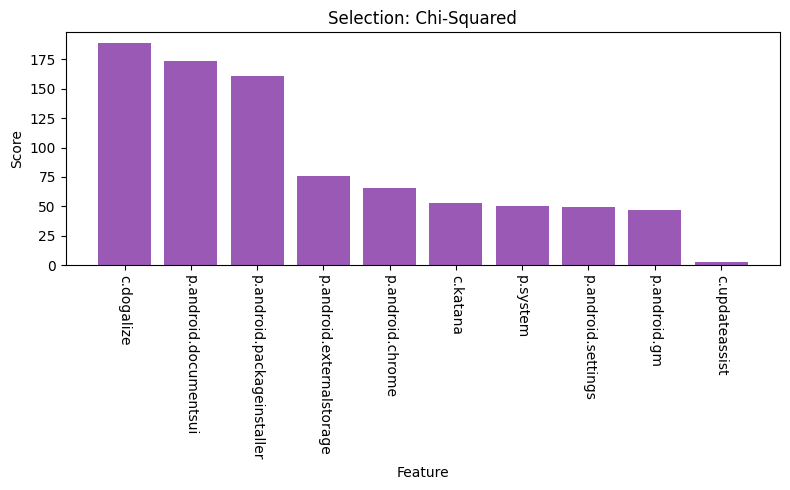

In [63]:
compare_feature_scores(attributes=chi2_minmax_features, score=chi2_minmax_scores, selection="Chi-Squared")

#
### Zoradené atribúty podľa dôležitosti `ANOVA selection`.

#### `Minmax`

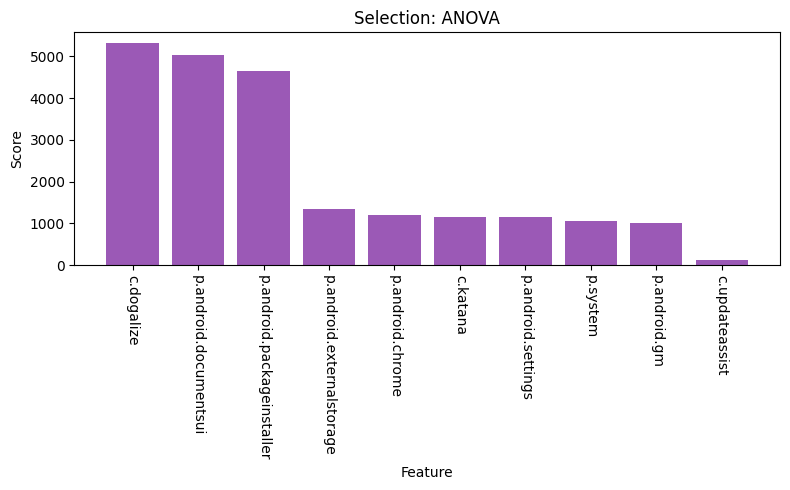

In [64]:
compare_feature_scores(attributes=anova_minmax_features, score=anova_minmax_scores, selection="ANOVA")

#### `Minmax` - `Box-Cox`

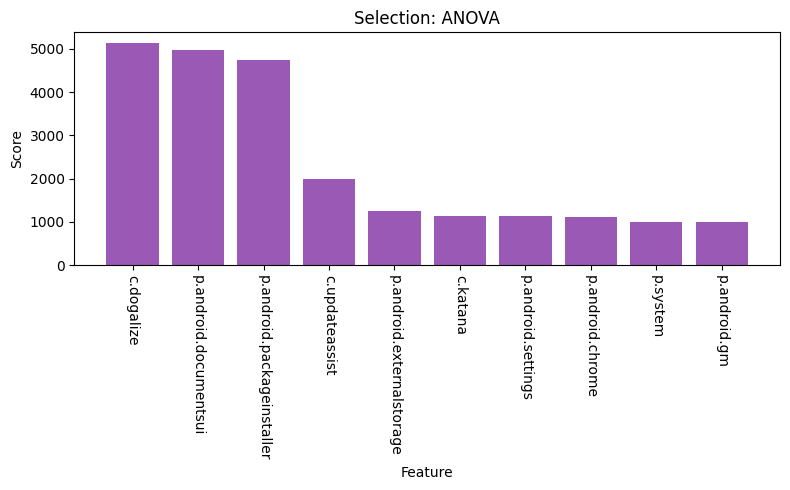

In [65]:
compare_feature_scores(attributes=anova_minmax_boxcox_features, score=anova_minmax_boxcox_scores, selection="ANOVA")

#### `Minmax` - `Yeo-Johnson`

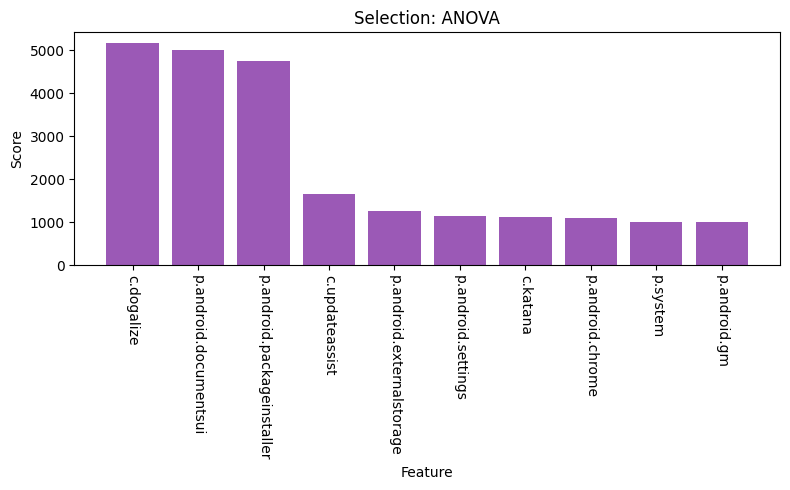

In [66]:
compare_feature_scores(attributes=anova_minmax_yeo_features, score=anova_minmax_yeo_scores, selection="ANOVA")

#### `Standard`

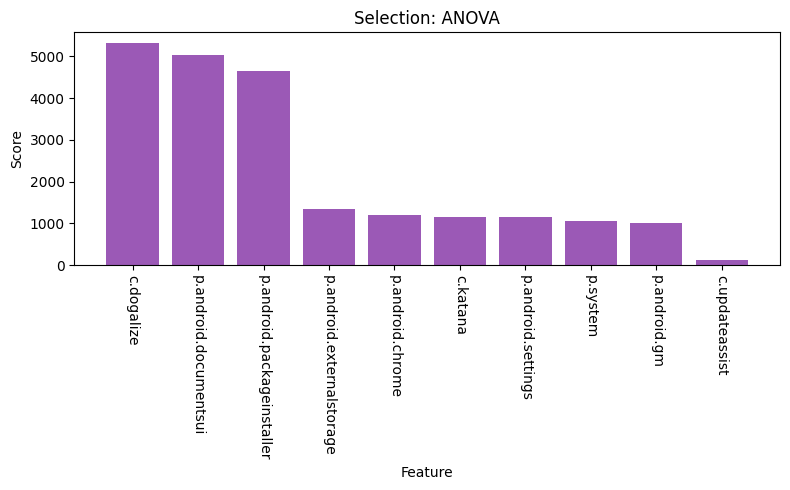

In [67]:
compare_feature_scores(attributes=anova_standard_features, score=anova_standard_scores, selection="ANOVA")

#### `Standard` - `Yeo-Johnson`

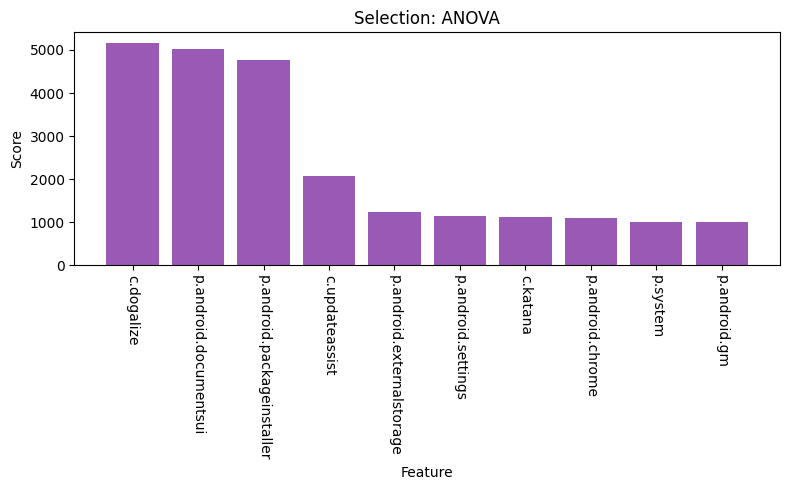

In [68]:
compare_feature_scores(attributes=anova_standard_yeo_features, score=anova_standard_yeo_scores, selection="ANOVA")

#
### Zoradené atribúty podľa dôležitosti `RFE` selection`.

#### `Minmax` prepisat

In [70]:
# compare_feature_scores(attributes=rfe_minmax_features, score=rfe_minmax_scores, selection="RFE")

#### `Minmax` - `Box-Cox`

In [71]:
# compare_feature_scores(attributes=rfe_minmax_boxcox_features, score=rfe_minmax_boxcox_scores, selection="RFE")

#### `Minmax` - `Yeo-Johnson`

In [72]:
# compare_feature_scores(attributes=rfe_minmax_yeo_features, score=rfe_minmax_yeo_scores, selection="RFE")

#### `Standard`

In [73]:
# compare_feature_scores(attributes=rfe_standard_features, score=rfe_standard_scores, selection="RFE")

#### `Standard` - `Yeo-Johnson`

In [74]:
# compare_feature_scores(attributes=rfe_standard_yeo_features, score=rfe_standard_yeo_scores, selection="RFE")

#
### Zoradené atribúty podľa dôležitosti `Lasso` selection.

#### `Minmax`

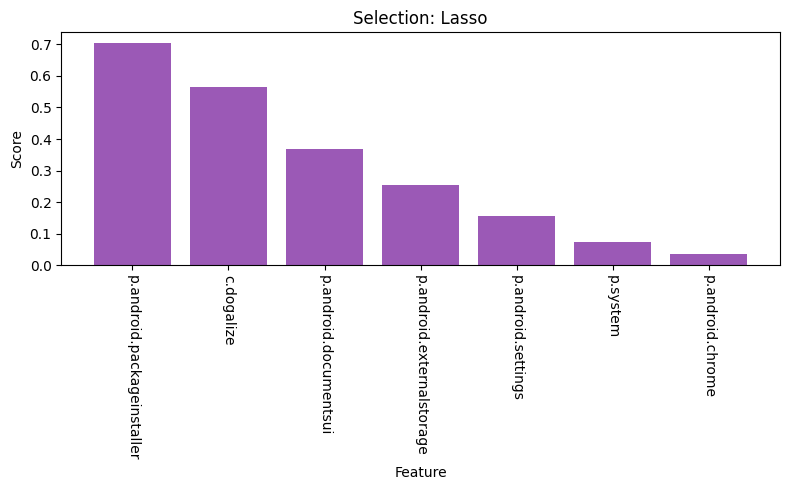

In [75]:
compare_feature_scores(attributes=lasso_minmax_features, score=lasso_minmax_scores, selection="Lasso")

#### `Minmax` - `Box-Cox`

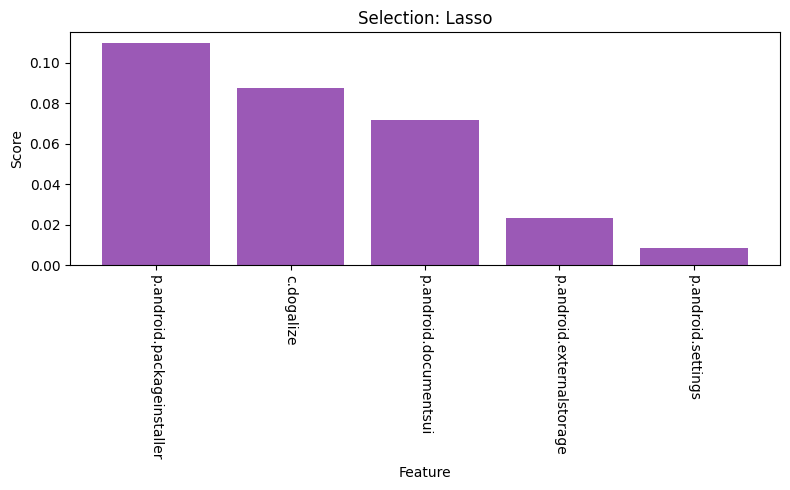

In [76]:
compare_feature_scores(attributes=lasso_minmax_boxcox_features, score=lasso_minmax_boxcox_scores, selection="Lasso")

#### `Minmax` - `Yeo-Johnson`

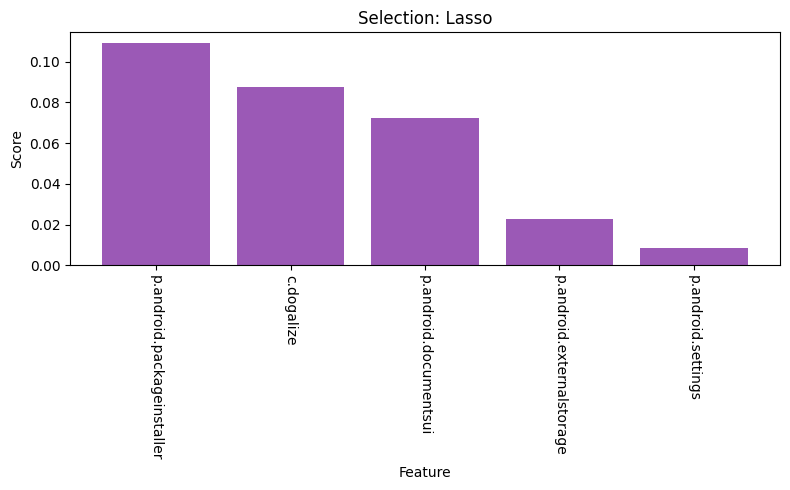

In [77]:
compare_feature_scores(attributes=lasso_minmax_yeo_features, score=lasso_minmax_yeo_scores, selection="Lasso")

#### `Standard`

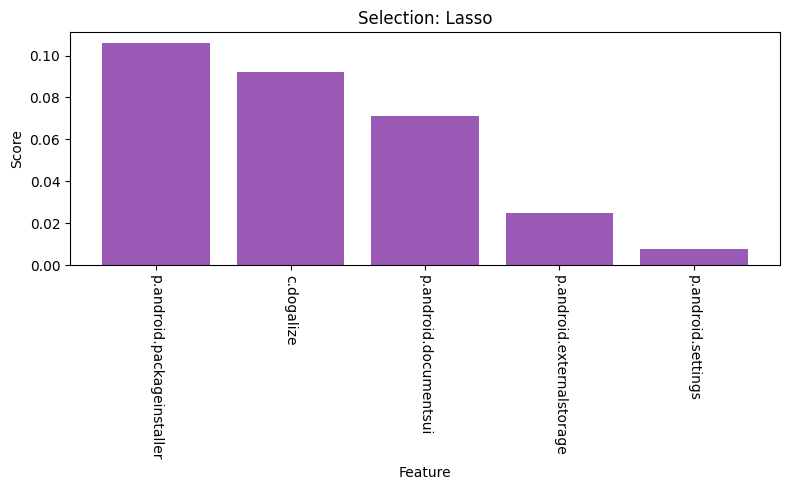

In [78]:
compare_feature_scores(attributes=lasso_standard_features, score=lasso_standard_scores, selection="Lasso")

#### `Standard` - `Yeo-Johnson`

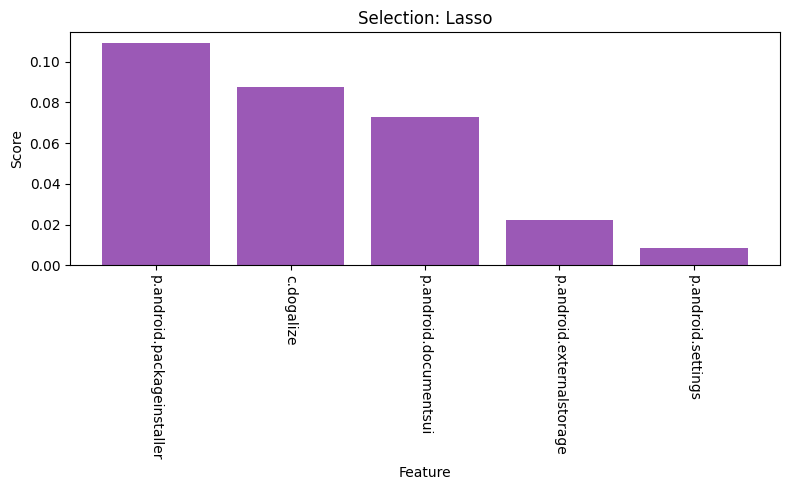

In [79]:
compare_feature_scores(attributes=lasso_standard_yeo_features, score=lasso_standard_yeo_scores, selection="Lasso")

## *C) Zdôvodnite Vaše voľby/rozhodnutie pre realizáciu.*

### Použili sme 4 techniky `feature selection`. Techniky sme vybrali z rôznych kategórií, pre možné rozdiely vo výsledkoch.
- #### **Filter:** `Chi-Squared` a `ANOVA`.
- #### **Wrapper:** `RFE`.
- #### **Embedded:** `Lasso`.
### V každej metóde `feature selection` sme aplikovali dáta v rôznej časti úpravy (neškálované, škálované, transformované). v metóde `RFE` sme však nepoužili všetky možnosti, pretože trvalo dlho, kým sa vykonali (10+ minút).
### Z výsledkov vidíme, že najviac informatívne `features` je `c.dogalize`. V každej technike je do 2. miesta.

#
# **2.3 Výber atribútov pre strojové učenie**

## *A) Upravte váš kód realizujúci predspracovanie trénovacej množiny na použitie predspracovania testovacej množiny v kontexte strojového učenia.*

### Niekroré časti kódu, ktoré sme už používali teraz spojíme spolu do funkcie, aby sme proces zjednotili a zaroveň novú funkciu mohli použiť v `pipeline`.

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
# def outliers_removal(X, y):
#     X = X.drop(columns=['ts', 'imei'], errors='ignore')
    
#     # Apply IQR-based outlier change while excluding 'c.updateassist'
#     X = change_outliers_iqr(df=X, exceptions=['c.updateassist'])
    
#     # Identify rows to remove based on 'c.updateassist' column threshold
#     lines_to_remove = X[X['c.updateassist'] > 5].index
    
#     # Drop the identified rows from both X and y
#     X = X.drop(lines_to_remove)
#     y = y.drop(lines_to_remove)
    
#     return X, y


class OutlierRemoval(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Compute IQR thresholds for each column
        self.thresholds_ = {}
        for col in X.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            self.thresholds_[col] = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
        return self

    def transform(self, X, y=None):
        X = X.drop(columns=['ts', 'imei'], errors='ignore')
        
        # Identify and drop rows based on stored thresholds
        outliers_index = set()
        for col, (lower_bound, upper_bound) in self.thresholds_.items():
            outliers_in_col = X[(X[col] < lower_bound) | (X[col] > upper_bound)].index
            outliers_index.update(outliers_in_col)

        # Drop all identified outlier rows
        X = X.drop(index=outliers_index)
        
        # Drop corresponding rows from y if provided
        if y is not None:
            y = y.drop(index=outliers_index)
            return X, y
        return X

# def apply_feature_selection(X, y):
#     selector_anova = SelectKBest(score_func=f_classif, k=10)
#     selector_anova.fit(X, y)
#     selected_features_mask = selector_anova.get_support()
#     new_X = X.loc[:, selected_features_mask]
    
#     return new_X

### Vytvorenie `pipeline`.

In [84]:
# X_test, y_test = outliers_removal(X_test, y_test)

pipeline = Pipeline(steps=[
    ('outliers', OutlierRemoval()),
    ('scaling', StandardScaler().set_output(transform='pandas')),
    ('transformation', PowerTransformer(method='yeo-johnson').set_output(transform='pandas')),
    #('feature_selection', FunctionTransformer(lambda X, y: apply_feature_selection(X, y), validate=False)),
])

pipeline.fit(kopia_X, kopia_y)

X_train_after = pipeline.transform(kopia_X)

print(X_train_after['c.dogalize'].mean())
print(X_train_standard_yeo['c.dogalize'].mean())

# X_test = pipeline.transform(X_test)

#X_selected, y_selected = pipeline.fit_transform(X_test, y_test)

ValueError: could not convert string to float: '2018-05-05 19:25:00'

## *B) Využite možnosti sklearn.pipeline.*